# imports

Вынес все импорты в шапку

In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

import optuna

from data_viz_functions import *

random_seed = 42

# reading data

Читаем и сразу объединяем в один датасет для более полной предобработки

In [2]:
DATA_DIR = 'kaggle/input'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

# viewing data

смотрим на данные

In [3]:
describe_nums(data.drop(columns=["client_id", "score_bki", "sample"]))

,unique,n/a count,count,mean,std,min,25%,50%,75%,max
income,1207,0,110148.000000,41012.648537,45399.735051,1000.000000,20000.000000,30000.000000,48000.000000,1000000.000000
app_date,120,0,nan,nan,nan,nan,nan,nan,nan,nan
age,52,0,110148.000000,39.249410,11.518063,21.000000,30.000000,37.000000,48.000000,72.000000
bki_request_cnt,40,0,110148.000000,2.005002,2.266926,0.000000,0.000000,1.000000,3.000000,53.000000
decline_app_cnt,24,0,110148.000000,0.273205,0.799099,0.000000,0.000000,0.000000,0.000000,33.000000
region_rating,7,0,110148.000000,56.751189,13.065923,20.000000,50.000000,50.000000,60.000000,80.000000
education,5,478,nan,nan,nan,nan,nan,nan,nan,nan
sna,4,0,110148.000000,1.731588,1.122652,1.000000,1.000000,1.000000,2.000000,4.000000
first_time,4,0,110148.000000,2.765570,1.010151,1.000000,2.000000,3.000000,4.000000,4.000000
home_address,3,0,110148.000000,1.574945,0.527562,1.000000,1.000000,2.000000,2.000000,3.000000


In [4]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

Unique values count: 52 
Q1: 30.0
Q3: 48.0
IQR: 18.0 
Outliers borders: [3.0, 75.0]


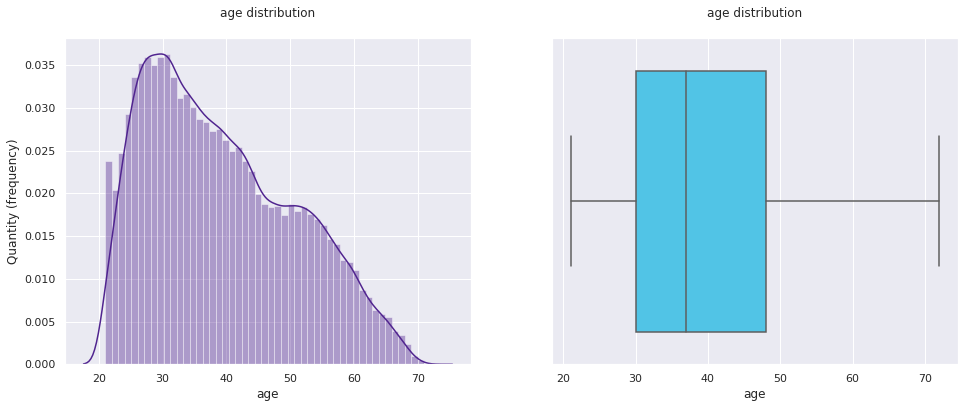

Unique values count: 102618 
Q1: -2.26044074
Q3: -1.5678840649999999
IQR: 0.6925566750000001 
Outliers borders: [-3.2992757525, -0.5290490524999998]


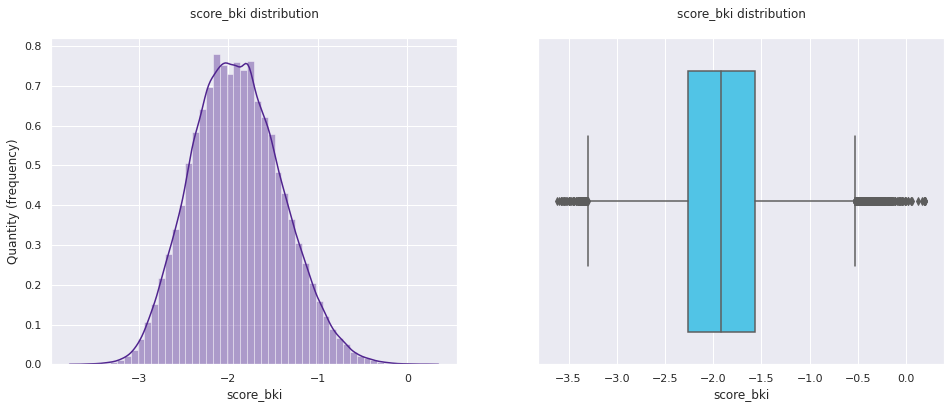

Unique values count: 24 
Q1: 0.0
Q3: 0.0
IQR: 0.0 
Outliers borders: [0.0, 0.0]


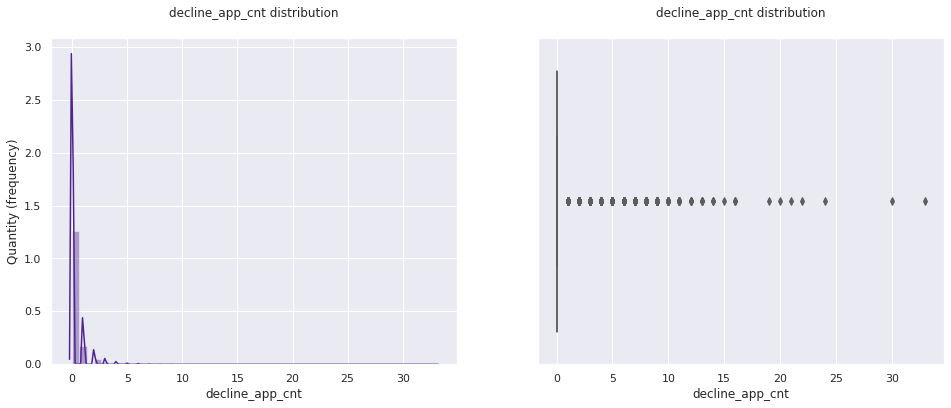

Unique values count: 40 
Q1: 0.0
Q3: 3.0
IQR: 3.0 
Outliers borders: [-4.5, 7.5]


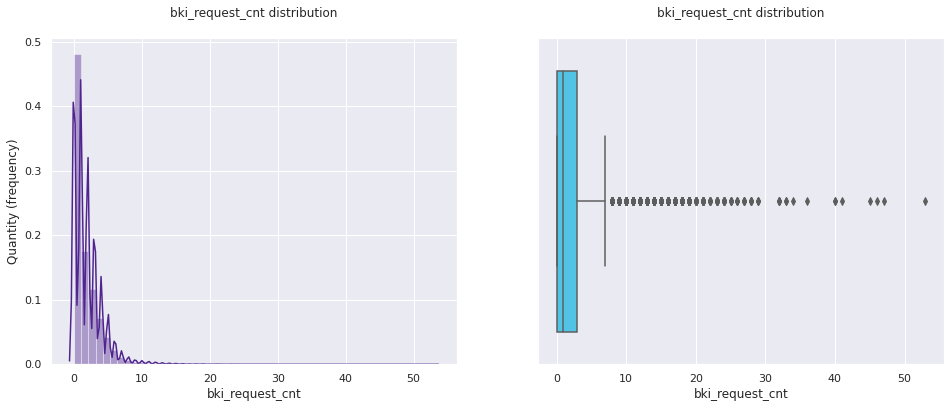

Unique values count: 1207 
Q1: 20000.0
Q3: 48000.0
IQR: 28000.0 
Outliers borders: [-22000.0, 90000.0]


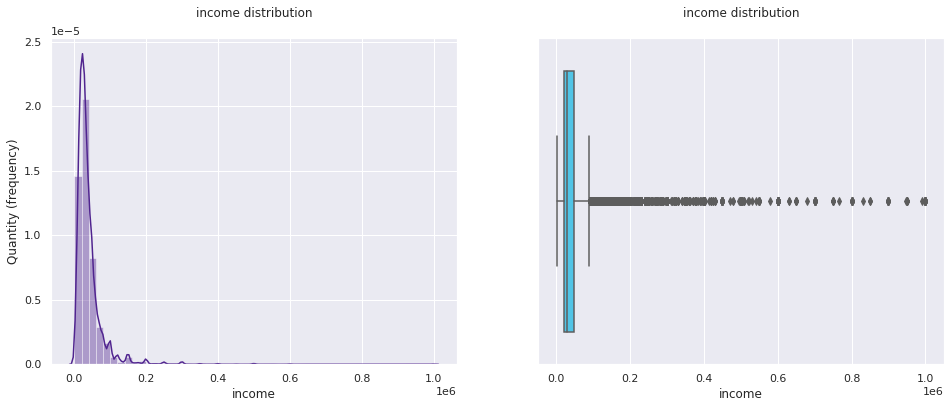

In [5]:
# уже по первой таблице видим, что большинство числовых значений имеют значительное смещение, посмотрим внимательнее

for n in num_cols:
    show_IQR(data[n])

In [6]:
# score_bki - единственная бесхвостая, остальные надо будет логорифмировать:
set(num_cols) - {"score_bki"}

{'age', 'bki_request_cnt', 'decline_app_cnt', 'income'}

<AxesSubplot:>

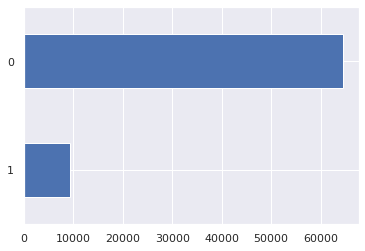

In [7]:
data.loc[data["sample"] == 1]["default"].value_counts(ascending=True).plot(kind="barh")

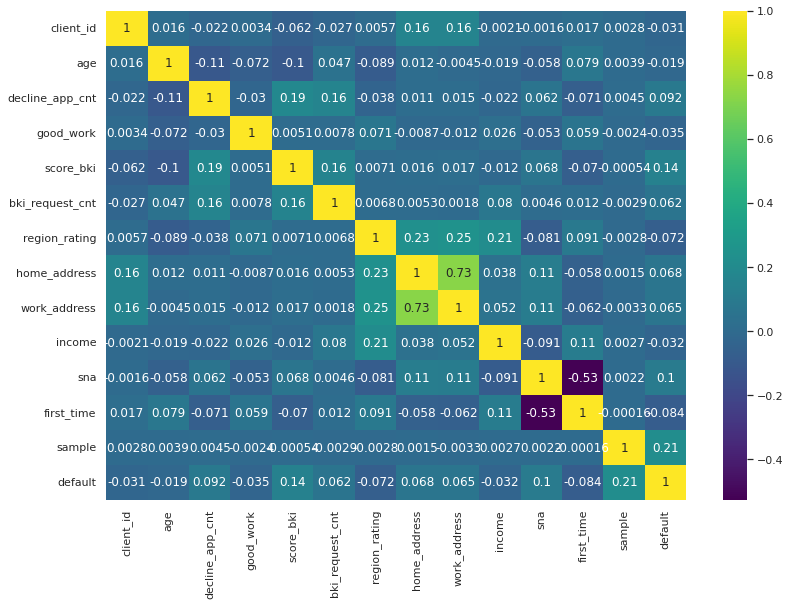

In [8]:
plt.subplots(figsize=(13, 9))
sns.heatmap(data.corr(), cmap="viridis", annot=True)
plt.show()

In [9]:
# есть сильно скоррелированные переменные, но это вредно только для логистической регрессии

# preprocessing

- убираем "технические" поля
- заполняем пропуски
- education превращаем в dummy
- текстовые и бинарные поля лейбл-энкодим (можно было бы ещё поработать с датами, достать месяца и недели, например)
- логорифмируем числовые переменные с хвостатыми распределениями
- нормализируем все числовые переменные

In [10]:
ids = data["client_id"]  # сохраним на всякий пожарный
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [11]:
# Заполнение пропуски 'education' наиболее частым значением 'SCH'
# Можно было бы выделить в отдельную категорию, "без образования", пробовал, качество от этого не повышается 
data["education"].fillna(data.education.mode(), inplace=True)

In [12]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

In [13]:
le = LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

for column in columns:
    data[column] = le.fit_transform(data[column])

In [14]:
# логорифмируем хвостатых

data['age'] = np.log(data['age'] + 1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['income'] = np.log(data['income'] + 1)
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)

In [15]:
# Нормализируем численные

for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))

In [16]:
# посмотрим что получилось

data.sample(5, random_state=random_seed).T

,74834,17526,75682,26882,28861
sex,0.000000,1.000000,0.000000,0.000000,1.000000
age,-1.130811,-0.773745,1.362924,-0.347997,-1.007707
car,0.000000,1.000000,0.000000,1.000000,0.000000
car_type,0.000000,1.000000,0.000000,0.000000,0.000000
decline_app_cnt,-0.418815,-0.418815,-0.418815,-0.418815,-0.418815
good_work,0.000000,0.000000,0.000000,0.000000,0.000000
score_bki,0.368124,-0.250086,-1.383239,0.317360,-0.992421
bki_request_cnt,1.109345,-1.334144,-1.334144,-0.281790,-0.281790
region_rating,6.000000,4.000000,3.000000,3.000000,3.000000
home_address,1.000000,1.000000,0.000000,0.000000,1.000000


<AxesSubplot:>

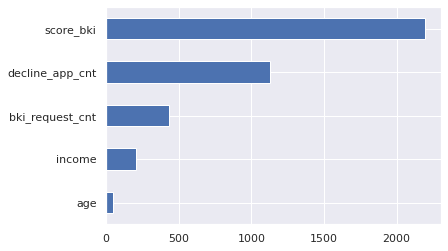

In [17]:
# значимость числовых переменных

imp_num = pd.Series(f_classif(data[num_cols], data["default"])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind="barh")

<AxesSubplot:>

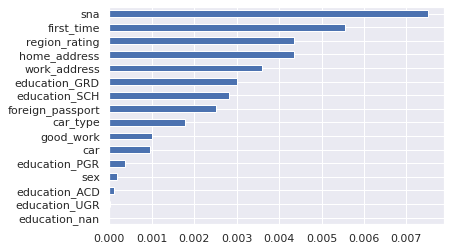

In [18]:
# значимость категориальных переменных

cols_to_plot = set(data.columns.tolist()) - set(num_cols + ["default", "sample"])

imp_cat = pd.Series(
    mutual_info_classif(
        data.query("sample == 1")[cols_to_plot],
        data.query("sample == 1")["default"],
        discrete_features=True,
    ),
    index=cols_to_plot,
)
imp_cat.sort_values().plot(kind="barh")

In [19]:
# можно попробовать поубирать или пообъединять малозначимые переменные, но уже руки не доходят

# undersampling

эта техника показала свою полезность в предыдущем ноутбуке

In [20]:
# для начала выделим тестовую часть

train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [22]:
# сам undersampling

rus = RandomUnderSampler(random_state=random_seed)
X_us, y_us = rus.fit_resample(X, y)


X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(
    X_us, y_us, test_size=0.10, shuffle=True, random_state=random_seed
)

# simple model

пробуем популярные классификаторы без параметров, сравниваем с гридсёрчнутой (в другом ноутбуке) логрегрессией

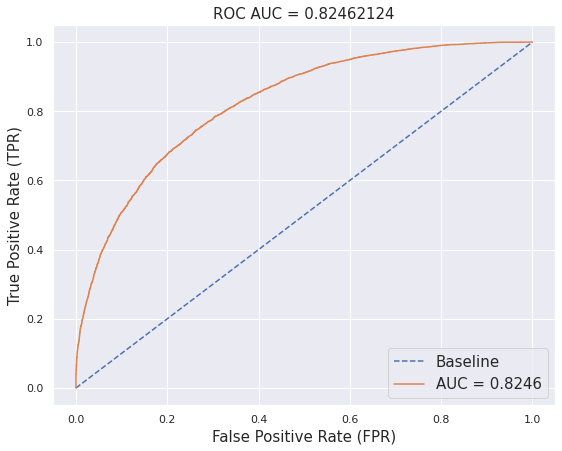

In [23]:
plot_roc_auc(
    y_train_us,
    CatBoostClassifier(silent=True)
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

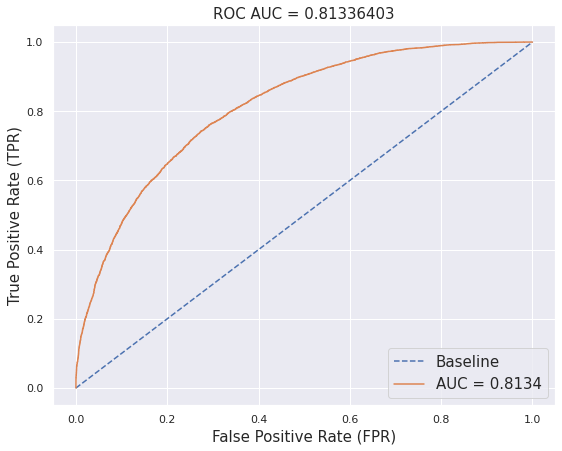

In [24]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

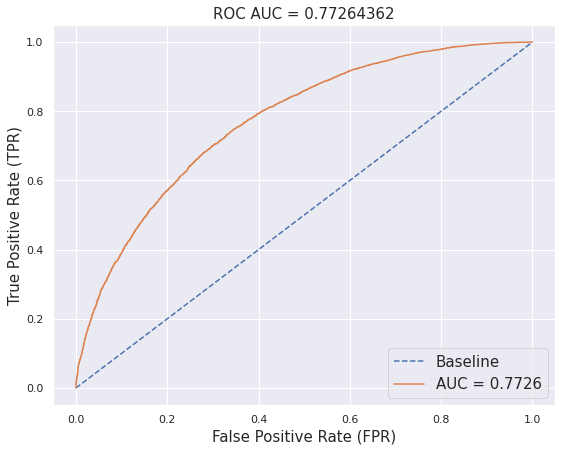

In [25]:
plot_roc_auc(
    y_train_us,
    HistGradientBoostingClassifier()
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)

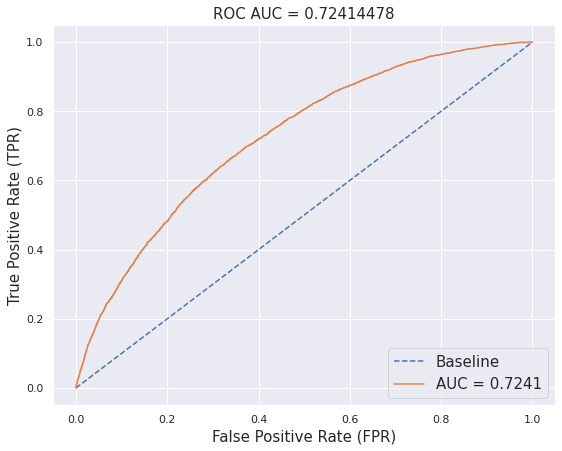

In [26]:
plot_roc_auc(
    y_train_us,
    LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed) # уже хорошо отгридсёрченная в бейзлайне
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)


# parameter tuning

подбираем наиболее эффективные параметры, используем **optuna**

Среди прочего попробовал оптимзировать как по минимальному из roc_auc кросс валидации, так и по медианному. Минимальный показал себя лучше. При медианном модель переобучается - мы получаем высокий результат на валидации, но плохой на кеггле

Почему lightgbm? Да, catboost мощнее, но lightgbm быстрее учится, а потому я надеюсь перебрать больше параметров

In [27]:
def objective(trial):

    from sklearn.model_selection import cross_val_score

    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = LGBMClassifier(**param)
    cv_roc_auc = cross_val_score(gbm, X_us, y_us, cv=8, scoring="roc_auc", n_jobs=-1)

    score = np.min(cv_roc_auc)
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, timeout=600, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)

[I 2021-12-19 13:07:41,816] A new study created in memory with name: no-name-7249cdaa-8b4b-43c4-9b72-ac7d415b5fcd


[LightGBM] [Warning] bagging_fraction is set=0.9786093172052638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786093172052638
[LightGBM] [Warning] lambda_l1 is set=2.025982252793655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.025982252793655
[LightGBM] [Warning] feature_fraction is set=0.4400724517400378, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4400724517400378
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=4.3151471599845685e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.3151471599845685e-07
[LightGBM] [Warning] bagging_fraction is set=0.9786093172052638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786093172052638
[LightGBM] [Warning] lambda_l1 is set=2.025982252793655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.025982252793655
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:07:47,207] Trial 0 finished with value: 0.7123116090503435 and parameters: {'lambda_l1': 2.025982252793655, 'lambda_l2': 4.3151471599845685e-07, 'num_leaves': 37, 'feature_fraction': 0.4400724517400378, 'bagging_fraction': 0.9786093172052638, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 0 with value: 0.7123116090503435.


[LightGBM] [Warning] bagging_fraction is set=0.7202381245173786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7202381245173786
[LightGBM] [Warning] lambda_l1 is set=3.636603705082989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.636603705082989e-05
[LightGBM] [Warning] feature_fraction is set=0.44205546436030596, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44205546436030596
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.046046377956189e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.046046377956189e-08
[LightGBM] [Warning] bagging_fraction is set=0.7202381245173786, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7202381245173786
[LightGBM] [Warning] lambda_l1 is set=3.636603705082989e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.636603705082989e-05
[LightGBM] [Warning] fea

[I 2021-12-19 13:07:51,574] Trial 1 finished with value: 0.6984141788325955 and parameters: {'lambda_l1': 3.636603705082989e-05, 'lambda_l2': 3.046046377956189e-08, 'num_leaves': 119, 'feature_fraction': 0.44205546436030596, 'bagging_fraction': 0.7202381245173786, 'bagging_freq': 4, 'min_child_samples': 25}. Best is trial 0 with value: 0.7123116090503435.


[LightGBM] [Warning] bagging_fraction is set=0.8557467008735071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557467008735071
[LightGBM] [Warning] lambda_l1 is set=5.9521832157596955e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9521832157596955e-05
[LightGBM] [Warning] feature_fraction is set=0.906306466494536, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.906306466494536
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.948041820880992e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.948041820880992e-06
[LightGBM] [Warning] bagging_fraction is set=0.8557467008735071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8557467008735071
[LightGBM] [Warning] lambda_l1 is set=5.9521832157596955e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9521832157596955e-05
[LightGBM] [Warning] fea

[I 2021-12-19 13:07:55,699] Trial 2 finished with value: 0.7022388320708358 and parameters: {'lambda_l1': 5.9521832157596955e-05, 'lambda_l2': 4.948041820880992e-06, 'num_leaves': 59, 'feature_fraction': 0.906306466494536, 'bagging_fraction': 0.8557467008735071, 'bagging_freq': 4, 'min_child_samples': 82}. Best is trial 0 with value: 0.7123116090503435.


[LightGBM] [Warning] bagging_fraction is set=0.8948495851853078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948495851853078
[LightGBM] [Warning] lambda_l1 is set=0.00018435342190168395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018435342190168395
[LightGBM] [Warning] feature_fraction is set=0.582989623915228, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.582989623915228
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.8328865853423346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8328865853423346
[LightGBM] [Warning] bagging_fraction is set=0.8948495851853078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8948495851853078
[LightGBM] [Warning] lambda_l1 is set=0.00018435342190168395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018435342190168395
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:07:57,924] Trial 3 finished with value: 0.7167701827148115 and parameters: {'lambda_l1': 0.00018435342190168395, 'lambda_l2': 1.8328865853423346, 'num_leaves': 13, 'feature_fraction': 0.582989623915228, 'bagging_fraction': 0.8948495851853078, 'bagging_freq': 5, 'min_child_samples': 89}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.9594084760995065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594084760995065
[LightGBM] [Warning] lambda_l1 is set=2.9052293672651447e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9052293672651447e-06
[LightGBM] [Warning] feature_fraction is set=0.6302532720177949, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6302532720177949
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.0963954454373589e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0963954454373589e-05
[LightGBM] [Warning] bagging_fraction is set=0.9594084760995065, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9594084760995065
[LightGBM] [Warning] lambda_l1 is set=2.9052293672651447e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9052293672651447e-06
[LightGBM] [Warning]

[I 2021-12-19 13:08:00,106] Trial 4 finished with value: 0.7038724522956663 and parameters: {'lambda_l1': 2.9052293672651447e-06, 'lambda_l2': 1.0963954454373589e-05, 'num_leaves': 66, 'feature_fraction': 0.6302532720177949, 'bagging_fraction': 0.9594084760995065, 'bagging_freq': 1, 'min_child_samples': 13}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.7641974636262852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7641974636262852
[LightGBM] [Warning] lambda_l1 is set=5.580785982625308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.580785982625308
[LightGBM] [Warning] feature_fraction is set=0.4975980136026825, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4975980136026825
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00717066548469262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00717066548469262
[LightGBM] [Warning] bagging_fraction is set=0.7641974636262852, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7641974636262852
[LightGBM] [Warning] lambda_l1 is set=5.580785982625308, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.580785982625308
[LightGBM] [Warning] feature_fraction is set=0

[I 2021-12-19 13:08:03,085] Trial 5 finished with value: 0.7144647525670134 and parameters: {'lambda_l1': 5.580785982625308, 'lambda_l2': 0.00717066548469262, 'num_leaves': 188, 'feature_fraction': 0.4975980136026825, 'bagging_fraction': 0.7641974636262852, 'bagging_freq': 2, 'min_child_samples': 72}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.8353796192769611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353796192769611
[LightGBM] [Warning] lambda_l1 is set=0.008413550230788545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008413550230788545
[LightGBM] [Warning] feature_fraction is set=0.41752650856714923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41752650856714923
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2393081093973883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2393081093973883e-08
[LightGBM] [Warning] bagging_fraction is set=0.8353796192769611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8353796192769611
[LightGBM] [Warning] lambda_l1 is set=0.008413550230788545, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008413550230788545
[LightGBM] [Warning] featu

[I 2021-12-19 13:08:06,690] Trial 6 finished with value: 0.7038199899155647 and parameters: {'lambda_l1': 0.008413550230788545, 'lambda_l2': 1.2393081093973883e-08, 'num_leaves': 102, 'feature_fraction': 0.41752650856714923, 'bagging_fraction': 0.8353796192769611, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.8078354634242102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078354634242102
[LightGBM] [Warning] lambda_l1 is set=0.012476674780923225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012476674780923225
[LightGBM] [Warning] feature_fraction is set=0.41579865482336115, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41579865482336115
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=1.6469113333020812e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6469113333020812e-06
[LightGBM] [Warning] bagging_fraction is set=0.8078354634242102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8078354634242102
[LightGBM] [Warning] lambda_l1 is set=0.012476674780923225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012476674780923225
[LightGBM] [Warning] featu

[I 2021-12-19 13:08:10,633] Trial 7 finished with value: 0.7027284809517842 and parameters: {'lambda_l1': 0.012476674780923225, 'lambda_l2': 1.6469113333020812e-06, 'num_leaves': 154, 'feature_fraction': 0.41579865482336115, 'bagging_fraction': 0.8078354634242102, 'bagging_freq': 7, 'min_child_samples': 76}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.5140774545628676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5140774545628676
[LightGBM] [Warning] lambda_l1 is set=0.00234689689732138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00234689689732138
[LightGBM] [Warning] feature_fraction is set=0.4449416631065499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4449416631065499
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.3218546289515204e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.3218546289515204e-05
[LightGBM] [Warning] bagging_fraction is set=0.5140774545628676, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5140774545628676
[LightGBM] [Warning] lambda_l1 is set=0.00234689689732138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00234689689732138
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:08:13,438] Trial 8 finished with value: 0.7036604168427557 and parameters: {'lambda_l1': 0.00234689689732138, 'lambda_l2': 3.3218546289515204e-05, 'num_leaves': 213, 'feature_fraction': 0.4449416631065499, 'bagging_fraction': 0.5140774545628676, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.6367456461591359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367456461591359
[LightGBM] [Warning] lambda_l1 is set=0.05356305483284982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05356305483284982
[LightGBM] [Warning] feature_fraction is set=0.4268299124016493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4268299124016493
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.97515553062573e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.97515553062573e-08
[LightGBM] [Warning] bagging_fraction is set=0.6367456461591359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6367456461591359
[LightGBM] [Warning] lambda_l1 is set=0.05356305483284982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05356305483284982
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:08:17,068] Trial 9 finished with value: 0.6921624118704879 and parameters: {'lambda_l1': 0.05356305483284982, 'lambda_l2': 4.97515553062573e-08, 'num_leaves': 130, 'feature_fraction': 0.4268299124016493, 'bagging_fraction': 0.6367456461591359, 'bagging_freq': 4, 'min_child_samples': 8}. Best is trial 3 with value: 0.7167701827148115.


[LightGBM] [Warning] bagging_fraction is set=0.603089659776306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.603089659776306
[LightGBM] [Warning] lambda_l1 is set=1.0982927303959028e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0982927303959028e-08
[LightGBM] [Warning] feature_fraction is set=0.7494315218756036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7494315218756036
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.503130845471341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.503130845471341
[LightGBM] [Warning] bagging_fraction is set=0.603089659776306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.603089659776306
[LightGBM] [Warning] lambda_l1 is set=1.0982927303959028e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0982927303959028e-08
[LightGBM] [Warning] feature_fract

[I 2021-12-19 13:08:18,592] Trial 10 finished with value: 0.7171432485288673 and parameters: {'lambda_l1': 1.0982927303959028e-08, 'lambda_l2': 6.503130845471341, 'num_leaves': 8, 'feature_fraction': 0.7494315218756036, 'bagging_fraction': 0.603089659776306, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.5790849982706895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5790849982706895
[LightGBM] [Warning] lambda_l1 is set=7.089722202585129e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.089722202585129e-08
[LightGBM] [Warning] feature_fraction is set=0.7985383878325442, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7985383878325442
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.869315364197646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.869315364197646
[LightGBM] [Warning] bagging_fraction is set=0.5790849982706895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5790849982706895
[LightGBM] [Warning] lambda_l1 is set=7.089722202585129e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.089722202585129e-08
[LightGBM] [Warning] feature_fract

[I 2021-12-19 13:08:19,963] Trial 11 finished with value: 0.7167002328746761 and parameters: {'lambda_l1': 7.089722202585129e-08, 'lambda_l2': 3.869315364197646, 'num_leaves': 5, 'feature_fraction': 0.7985383878325442, 'bagging_fraction': 0.5790849982706895, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.4071297179297154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4071297179297154
[LightGBM] [Warning] lambda_l1 is set=2.757577481939265e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.757577481939265e-08
[LightGBM] [Warning] feature_fraction is set=0.6449019274773967, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6449019274773967
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=6.327419270091904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.327419270091904
[LightGBM] [Warning] bagging_fraction is set=0.4071297179297154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4071297179297154
[LightGBM] [Warning] lambda_l1 is set=2.757577481939265e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.757577481939265e-08
[LightGBM] [Warning] feature_fract

[I 2021-12-19 13:08:21,009] Trial 12 finished with value: 0.7040939601227619 and parameters: {'lambda_l1': 2.757577481939265e-08, 'lambda_l2': 6.327419270091904, 'num_leaves': 2, 'feature_fraction': 0.6449019274773967, 'bagging_fraction': 0.4071297179297154, 'bagging_freq': 6, 'min_child_samples': 100}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.6263088056141884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263088056141884
[LightGBM] [Warning] lambda_l1 is set=4.661507582734124e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.661507582734124e-07
[LightGBM] [Warning] feature_fraction is set=0.7461101080187761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7461101080187761
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.1204982280068014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1204982280068014
[LightGBM] [Warning] bagging_fraction is set=0.6263088056141884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263088056141884
[LightGBM] [Warning] lambda_l1 is set=4.661507582734124e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.661507582734124e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:08:25,848] Trial 13 finished with value: 0.6927431412724459 and parameters: {'lambda_l1': 4.661507582734124e-07, 'lambda_l2': 0.1204982280068014, 'num_leaves': 255, 'feature_fraction': 0.7461101080187761, 'bagging_fraction': 0.6263088056141884, 'bagging_freq': 6, 'min_child_samples': 48}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.5079714463899178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5079714463899178
[LightGBM] [Warning] lambda_l1 is set=3.2336040338083294e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2336040338083294e-06
[LightGBM] [Warning] feature_fraction is set=0.5749625579822564, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5749625579822564
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.20460243888852508, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.20460243888852508
[LightGBM] [Warning] bagging_fraction is set=0.5079714463899178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5079714463899178
[LightGBM] [Warning] lambda_l1 is set=3.2336040338083294e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2336040338083294e-06
[LightGBM] [Warning] featu

[I 2021-12-19 13:08:28,713] Trial 14 finished with value: 0.7081503222064511 and parameters: {'lambda_l1': 3.2336040338083294e-06, 'lambda_l2': 0.20460243888852508, 'num_leaves': 36, 'feature_fraction': 0.5749625579822564, 'bagging_fraction': 0.5079714463899178, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.8965868241508798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8965868241508798
[LightGBM] [Warning] lambda_l1 is set=0.00014763219446130678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014763219446130678
[LightGBM] [Warning] feature_fraction is set=0.8578166751245612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8578166751245612[LightGBM] [Warning] bagging_fraction is set=0.8965868241508798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8965868241508798
[LightGBM] [Warning] lambda_l1 is set=0.00014763219446130678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00014763219446130678
[LightGBM] [Warning] feature_fraction is set=0.8578166751245612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8578166751245612
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM

[I 2021-12-19 13:08:33,346] Trial 15 finished with value: 0.7027896870619027 and parameters: {'lambda_l1': 0.00014763219446130678, 'lambda_l2': 0.000964347294572345, 'num_leaves': 79, 'feature_fraction': 0.8578166751245612, 'bagging_fraction': 0.8965868241508798, 'bagging_freq': 5, 'min_child_samples': 59}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.6898921818064466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6898921818064466
[LightGBM] [Warning] lambda_l1 is set=0.16387842710911138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16387842710911138
[LightGBM] [Warning] feature_fraction is set=0.9912416234252275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9912416234252275
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.14161043713389845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14161043713389845
[LightGBM] [Warning] bagging_fraction is set=0.6898921818064466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6898921818064466
[LightGBM] [Warning] lambda_l1 is set=0.16387842710911138, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16387842710911138
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:08:36,724] Trial 16 finished with value: 0.7071265771503018 and parameters: {'lambda_l1': 0.16387842710911138, 'lambda_l2': 0.14161043713389845, 'num_leaves': 36, 'feature_fraction': 0.9912416234252275, 'bagging_fraction': 0.6898921818064466, 'bagging_freq': 5, 'min_child_samples': 91}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.9122492364235106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9122492364235106
[LightGBM] [Warning] lambda_l1 is set=0.0008351455995560868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008351455995560868
[LightGBM] [Warning] feature_fraction is set=0.7353643386124954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7353643386124954
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0073524125412930815, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0073524125412930815
[LightGBM] [Warning] bagging_fraction is set=0.9122492364235106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9122492364235106
[LightGBM] [Warning] lambda_l1 is set=0.0008351455995560868, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008351455995560868
[LightGBM] [Warning] featu

[I 2021-12-19 13:08:39,508] Trial 17 finished with value: 0.7151467635083342 and parameters: {'lambda_l1': 0.0008351455995560868, 'lambda_l2': 0.0073524125412930815, 'num_leaves': 11, 'feature_fraction': 0.7353643386124954, 'bagging_fraction': 0.9122492364235106, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.501944668172559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501944668172559
[LightGBM] [Warning] lambda_l1 is set=4.348950369275255e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348950369275255e-06
[LightGBM] [Warning] feature_fraction is set=0.5683034507931864, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5683034507931864
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.8416179514869006, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8416179514869006
[LightGBM] [Warning] bagging_fraction is set=0.501944668172559, subsample=1.0 will be ignored. Current value: bagging_fraction=0.501944668172559
[LightGBM] [Warning] lambda_l1 is set=4.348950369275255e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.348950369275255e-06
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:08:43,448] Trial 18 finished with value: 0.7044990862802132 and parameters: {'lambda_l1': 4.348950369275255e-06, 'lambda_l2': 0.8416179514869006, 'num_leaves': 99, 'feature_fraction': 0.5683034507931864, 'bagging_fraction': 0.501944668172559, 'bagging_freq': 7, 'min_child_samples': 89}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.7615601491534014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7615601491534014
[LightGBM] [Warning] lambda_l1 is set=1.606086520412611e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.606086520412611e-08
[LightGBM] [Warning] feature_fraction is set=0.673399356310178, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.673399356310178
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.014169982257351227, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014169982257351227
[LightGBM] [Warning] bagging_fraction is set=0.7615601491534014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7615601491534014
[LightGBM] [Warning] lambda_l1 is set=1.606086520412611e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.606086520412611e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:08:47,046] Trial 19 finished with value: 0.7076373567121242 and parameters: {'lambda_l1': 1.606086520412611e-08, 'lambda_l2': 0.014169982257351227, 'num_leaves': 40, 'feature_fraction': 0.673399356310178, 'bagging_fraction': 0.7615601491534014, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.5754522422855204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5754522422855204
[LightGBM] [Warning] lambda_l1 is set=1.3568669926446397e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568669926446397e-07
[LightGBM] [Warning] feature_fraction is set=0.5721104515059383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5721104515059383
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=8.499543712020978, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.499543712020978
[LightGBM] [Warning] bagging_fraction is set=0.5754522422855204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5754522422855204
[LightGBM] [Warning] lambda_l1 is set=1.3568669926446397e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3568669926446397e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:08:50,667] Trial 20 finished with value: 0.7087652978843089 and parameters: {'lambda_l1': 1.3568669926446397e-07, 'lambda_l2': 8.499543712020978, 'num_leaves': 84, 'feature_fraction': 0.5721104515059383, 'bagging_fraction': 0.5754522422855204, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.5746997361913988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5746997361913988
[LightGBM] [Warning] lambda_l1 is set=3.012065643036482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.012065643036482e-07
[LightGBM] [Warning] feature_fraction is set=0.8107068051289579, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8107068051289579
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.8962429330228865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8962429330228865
[LightGBM] [Warning] bagging_fraction is set=0.5746997361913988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5746997361913988
[LightGBM] [Warning] lambda_l1 is set=3.012065643036482e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.012065643036482e-07
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:08:52,139] Trial 21 finished with value: 0.7134125903883091 and parameters: {'lambda_l1': 3.012065643036482e-07, 'lambda_l2': 1.8962429330228865, 'num_leaves': 4, 'feature_fraction': 0.8107068051289579, 'bagging_fraction': 0.5746997361913988, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.6535319216144446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6535319216144446
[LightGBM] [Warning] lambda_l1 is set=1.0685680103529721e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0685680103529721e-08
[LightGBM] [Warning] feature_fraction is set=0.8065332264568356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8065332264568356
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.8020207868265768, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8020207868265768
[LightGBM] [Warning] bagging_fraction is set=0.6535319216144446, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6535319216144446
[LightGBM] [Warning] lambda_l1 is set=1.0685680103529721e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0685680103529721e-08
[LightGBM] [Warning] feature

[I 2021-12-19 13:08:54,438] Trial 22 finished with value: 0.7130344240650767 and parameters: {'lambda_l1': 1.0685680103529721e-08, 'lambda_l2': 0.8020207868265768, 'num_leaves': 21, 'feature_fraction': 0.8065332264568356, 'bagging_fraction': 0.6535319216144446, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.5796070975583594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5796070975583594
[LightGBM] [Warning] lambda_l1 is set=8.600943430192831e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.600943430192831e-08
[LightGBM] [Warning] feature_fraction is set=0.7295121992109597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7295121992109597
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.058282914689617084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.058282914689617084
[LightGBM] [Warning] bagging_fraction is set=0.5796070975583594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5796070975583594
[LightGBM] [Warning] lambda_l1 is set=8.600943430192831e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.600943430192831e-08
[LightGBM] [Warning] feature

[I 2021-12-19 13:08:57,316] Trial 23 finished with value: 0.7051424790806259 and parameters: {'lambda_l1': 8.600943430192831e-08, 'lambda_l2': 0.058282914689617084, 'num_leaves': 49, 'feature_fraction': 0.7295121992109597, 'bagging_fraction': 0.5796070975583594, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.4044468187679883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4044468187679883
[LightGBM] [Warning] lambda_l1 is set=8.513928361383919e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.513928361383919e-07
[LightGBM] [Warning] feature_fraction is set=0.7944307554036174, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7944307554036174
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.00046934610665192957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00046934610665192957
[LightGBM] [Warning] bagging_fraction is set=0.4044468187679883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4044468187679883
[LightGBM] [Warning] lambda_l1 is set=8.513928361383919e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.513928361383919e-07
[LightGBM] [Warning] fea

[I 2021-12-19 13:08:59,091] Trial 24 finished with value: 0.7133819873332499 and parameters: {'lambda_l1': 8.513928361383919e-07, 'lambda_l2': 0.00046934610665192957, 'num_leaves': 16, 'feature_fraction': 0.7944307554036174, 'bagging_fraction': 0.4044468187679883, 'bagging_freq': 7, 'min_child_samples': 85}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.46737681692226524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46737681692226524
[LightGBM] [Warning] lambda_l1 is set=1.9085241210430472e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9085241210430472e-05
[LightGBM] [Warning] feature_fraction is set=0.9039525465903449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9039525465903449
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.7867399955827272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7867399955827272
[LightGBM] [Warning] bagging_fraction is set=0.46737681692226524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46737681692226524
[LightGBM] [Warning] lambda_l1 is set=1.9085241210430472e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9085241210430472e-05
[LightGBM] [Warning] fea

[I 2021-12-19 13:09:01,157] Trial 25 finished with value: 0.7075674068719888 and parameters: {'lambda_l1': 1.9085241210430472e-05, 'lambda_l2': 1.7867399955827272, 'num_leaves': 22, 'feature_fraction': 0.9039525465903449, 'bagging_fraction': 0.46737681692226524, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.6977250983682356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6977250983682356
[LightGBM] [Warning] lambda_l1 is set=1.0838411871183589e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0838411871183589e-07
[LightGBM] [Warning] feature_fraction is set=0.6913202576971008, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6913202576971008
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=6.714825067407367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.714825067407367
[LightGBM] [Warning] bagging_fraction is set=0.6977250983682356, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6977250983682356
[LightGBM] [Warning] lambda_l1 is set=1.0838411871183589e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0838411871183589e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:09:04,579] Trial 26 finished with value: 0.705047755338776 and parameters: {'lambda_l1': 1.0838411871183589e-07, 'lambda_l2': 6.714825067407367, 'num_leaves': 65, 'feature_fraction': 0.6913202576971008, 'bagging_fraction': 0.6977250983682356, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.6031467336013654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6031467336013654
[LightGBM] [Warning] lambda_l1 is set=1.087378642165637e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.087378642165637e-05
[LightGBM] [Warning] feature_fraction is set=0.5187730495330758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5187730495330758
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.38134290459051007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.38134290459051007
[LightGBM] [Warning] bagging_fraction is set=0.6031467336013654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6031467336013654
[LightGBM] [Warning] lambda_l1 is set=1.087378642165637e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.087378642165637e-05
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:09:08,956] Trial 27 finished with value: 0.7026913200992122 and parameters: {'lambda_l1': 1.087378642165637e-05, 'lambda_l2': 0.38134290459051007, 'num_leaves': 149, 'feature_fraction': 0.5187730495330758, 'bagging_fraction': 0.6031467336013654, 'bagging_freq': 3, 'min_child_samples': 59}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.544737820252866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.544737820252866
[LightGBM] [Warning] lambda_l1 is set=0.00032770037347176035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032770037347176035
[LightGBM] [Warning] feature_fraction is set=0.6180720962021458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6180720962021458[LightGBM] [Warning] bagging_fraction is set=0.544737820252866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.544737820252866
[LightGBM] [Warning] lambda_l1 is set=0.00032770037347176035, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032770037347176035
[LightGBM] [Warning] feature_fraction is set=0.6180720962021458, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6180720962021458
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [W

[I 2021-12-19 13:09:11,170] Trial 28 finished with value: 0.7126679160485336 and parameters: {'lambda_l1': 0.00032770037347176035, 'lambda_l2': 2.0011931188372136, 'num_leaves': 24, 'feature_fraction': 0.6180720962021458, 'bagging_fraction': 0.544737820252866, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.9895040870459826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9895040870459826
[LightGBM] [Warning] lambda_l1 is set=0.7184714690205609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7184714690205609
[LightGBM] [Warning] feature_fraction is set=0.8573191134423198, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8573191134423198
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.024542828532000696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024542828532000696
[LightGBM] [Warning] bagging_fraction is set=0.9895040870459826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9895040870459826
[LightGBM] [Warning] lambda_l1 is set=0.7184714690205609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7184714690205609
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:09:14,224] Trial 29 finished with value: 0.7084315788553293 and parameters: {'lambda_l1': 0.7184714690205609, 'lambda_l2': 0.024542828532000696, 'num_leaves': 47, 'feature_fraction': 0.8573191134423198, 'bagging_fraction': 0.9895040870459826, 'bagging_freq': 7, 'min_child_samples': 95}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.66692511634728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66692511634728
[LightGBM] [Warning] lambda_l1 is set=4.916640306242811e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.916640306242811e-08
[LightGBM] [Warning] feature_fraction is set=0.7729559473282986, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7729559473282986
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.6740884924808871, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6740884924808871
[LightGBM] [Warning] bagging_fraction is set=0.66692511634728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66692511634728
[LightGBM] [Warning] lambda_l1 is set=4.916640306242811e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.916640306242811e-08
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:09:15,349] Trial 30 finished with value: 0.7034574894419461 and parameters: {'lambda_l1': 4.916640306242811e-08, 'lambda_l2': 0.6740884924808871, 'num_leaves': 2, 'feature_fraction': 0.7729559473282986, 'bagging_fraction': 0.66692511634728, 'bagging_freq': 7, 'min_child_samples': 64}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.9315327997177395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9315327997177395
[LightGBM] [Warning] lambda_l1 is set=0.0008048928742037285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008048928742037285
[LightGBM] [Warning] feature_fraction is set=0.7352451558218771, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7352451558218771
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0017226170426596957, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017226170426596957
[LightGBM] [Warning] bagging_fraction is set=0.9315327997177395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9315327997177395
[LightGBM] [Warning] lambda_l1 is set=0.0008048928742037285, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008048928742037285
[LightGBM] [Warning] featu

[I 2021-12-19 13:09:17,574] Trial 31 finished with value: 0.7127334940236605 and parameters: {'lambda_l1': 0.0008048928742037285, 'lambda_l2': 0.0017226170426596957, 'num_leaves': 23, 'feature_fraction': 0.7352451558218771, 'bagging_fraction': 0.9315327997177395, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.9413766903531512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413766903531512
[LightGBM] [Warning] lambda_l1 is set=0.0013916835313788946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013916835313788946
[LightGBM] [Warning] feature_fraction is set=0.7004732974638002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7004732974638002
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.343694592219559e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.343694592219559e-05
[LightGBM] [Warning] bagging_fraction is set=0.9413766903531512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9413766903531512
[LightGBM] [Warning] lambda_l1 is set=0.0013916835313788946, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013916835313788946
[LightGBM] [Warning] featu

[I 2021-12-19 13:09:19,400] Trial 32 finished with value: 0.7135772639702946 and parameters: {'lambda_l1': 0.0013916835313788946, 'lambda_l2': 8.343694592219559e-05, 'num_leaves': 12, 'feature_fraction': 0.7004732974638002, 'bagging_fraction': 0.9413766903531512, 'bagging_freq': 6, 'min_child_samples': 35}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.8728585984302919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728585984302919
[LightGBM] [Warning] lambda_l1 is set=0.00011088875993547926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011088875993547926
[LightGBM] [Warning] feature_fraction is set=0.8570019261578158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8570019261578158
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.004876384297489262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004876384297489262
[LightGBM] [Warning] bagging_fraction is set=0.8728585984302919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8728585984302919
[LightGBM] [Warning] lambda_l1 is set=0.00011088875993547926, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00011088875993547926
[LightGBM] [Warning] fea

[I 2021-12-19 13:09:22,010] Trial 33 finished with value: 0.7073444417565571 and parameters: {'lambda_l1': 0.00011088875993547926, 'lambda_l2': 0.004876384297489262, 'num_leaves': 35, 'feature_fraction': 0.8570019261578158, 'bagging_fraction': 0.8728585984302919, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.73450949839167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73450949839167
[LightGBM] [Warning] lambda_l1 is set=1.0699494230673005e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0699494230673005e-06
[LightGBM] [Warning] feature_fraction is set=0.7716642065009351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7716642065009351
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.057827885245353296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.057827885245353296
[LightGBM] [Warning] bagging_fraction is set=0.73450949839167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73450949839167[LightGBM] [Warning] bagging_fraction is set=0.73450949839167, subsample=1.0 will be ignored. Current value: bagging_fraction=0.73450949839167
[LightGBM] [Warning] lambda_l1 

[I 2021-12-19 13:09:24,885] Trial 34 finished with value: 0.7047001920706027 and parameters: {'lambda_l1': 1.0699494230673005e-06, 'lambda_l2': 0.057827885245353296, 'num_leaves': 51, 'feature_fraction': 0.7716642065009351, 'bagging_fraction': 0.73450949839167, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.9123074497343603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9123074497343603
[LightGBM] [Warning] lambda_l1 is set=0.004006738300000821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004006738300000821
[LightGBM] [Warning] feature_fraction is set=0.6576828189979698, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6576828189979698
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.414251997394825, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.414251997394825
[LightGBM] [Warning] bagging_fraction is set=0.9123074497343603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9123074497343603
[LightGBM] [Warning] lambda_l1 is set=0.004006738300000821, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004006738300000821
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:09:28,566] Trial 35 finished with value: 0.7096032386775983 and parameters: {'lambda_l1': 0.004006738300000821, 'lambda_l2': 9.414251997394825, 'num_leaves': 74, 'feature_fraction': 0.6576828189979698, 'bagging_fraction': 0.9123074497343603, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.8066961835474138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8066961835474138
[LightGBM] [Warning] lambda_l1 is set=0.00028321085253821526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028321085253821526
[LightGBM] [Warning] feature_fraction is set=0.6169191918334447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6169191918334447
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=2.3613915515652426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3613915515652426
[LightGBM] [Warning] bagging_fraction is set=0.8066961835474138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8066961835474138
[LightGBM] [Warning] lambda_l1 is set=0.00028321085253821526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028321085253821526
[LightGBM] [Warning] feature

[I 2021-12-19 13:09:31,890] Trial 36 finished with value: 0.709402861531377 and parameters: {'lambda_l1': 0.00028321085253821526, 'lambda_l2': 2.3613915515652426, 'num_leaves': 59, 'feature_fraction': 0.6169191918334447, 'bagging_fraction': 0.8066961835474138, 'bagging_freq': 7, 'min_child_samples': 40}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.999405748256779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999405748256779
[LightGBM] [Warning] lambda_l1 is set=2.9852892568474722e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9852892568474722e-05
[LightGBM] [Warning] feature_fraction is set=0.7270327415795385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7270327415795385
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.003914035398234618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003914035398234618
[LightGBM] [Warning] bagging_fraction is set=0.999405748256779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999405748256779
[LightGBM] [Warning] lambda_l1 is set=2.9852892568474722e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9852892568474722e-05
[LightGBM] [Warning] feature

[I 2021-12-19 13:09:34,555] Trial 37 finished with value: 0.7073590146399187 and parameters: {'lambda_l1': 2.9852892568474722e-05, 'lambda_l2': 0.003914035398234618, 'num_leaves': 31, 'feature_fraction': 0.7270327415795385, 'bagging_fraction': 0.999405748256779, 'bagging_freq': 5, 'min_child_samples': 49}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.837631628092646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.837631628092646
[LightGBM] [Warning] lambda_l1 is set=0.028990684235934795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028990684235934795
[LightGBM] [Warning] feature_fraction is set=0.8375226202695729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8375226202695729
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.03241360376450387, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03241360376450387
[LightGBM] [Warning] bagging_fraction is set=0.837631628092646, subsample=1.0 will be ignored. Current value: bagging_fraction=0.837631628092646
[LightGBM] [Warning] lambda_l1 is set=0.028990684235934795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.028990684235934795
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:09:36,387] Trial 38 finished with value: 0.7151310976587206 and parameters: {'lambda_l1': 0.028990684235934795, 'lambda_l2': 0.03241360376450387, 'num_leaves': 11, 'feature_fraction': 0.8375226202695729, 'bagging_fraction': 0.837631628092646, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.8757820897588444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8757820897588444
[LightGBM] [Warning] lambda_l1 is set=0.28176342876458554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28176342876458554[LightGBM] [Warning] bagging_fraction is set=0.8757820897588444, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8757820897588444

[LightGBM] [Warning] lambda_l1 is set=0.28176342876458554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28176342876458554
[LightGBM] [Warning] feature_fraction is set=0.916961459019499, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.916961459019499
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.044107429009159e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.044107429009159e-05
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:09:40,467] Trial 39 finished with value: 0.6960336983354852 and parameters: {'lambda_l1': 0.28176342876458554, 'lambda_l2': 9.044107429009159e-05, 'num_leaves': 98, 'feature_fraction': 0.916961459019499, 'bagging_fraction': 0.8757820897588444, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 10 with value: 0.7171432485288673.


[LightGBM] [Warning] bagging_fraction is set=0.792186797360094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.792186797360094
[LightGBM] [Warning] lambda_l1 is set=8.86015037344885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.86015037344885
[LightGBM] [Warning] feature_fraction is set=0.5193587128653058, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5193587128653058
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.452714439393865e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.452714439393865e-07
[LightGBM] [Warning] bagging_fraction is set=0.792186797360094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.792186797360094
[LightGBM] [Warning] lambda_l1 is set=8.86015037344885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.86015037344885
[LightGBM] [Warning] feature_fraction is set=0.519

[I 2021-12-19 13:09:42,533] Trial 40 finished with value: 0.7173654850001312 and parameters: {'lambda_l1': 8.86015037344885, 'lambda_l2': 2.452714439393865e-07, 'num_leaves': 181, 'feature_fraction': 0.5193587128653058, 'bagging_fraction': 0.792186797360094, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.8055827268386266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8055827268386266
[LightGBM] [Warning] lambda_l1 is set=5.682437940949935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.682437940949935
[LightGBM] [Warning] feature_fraction is set=0.5115692982872861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5115692982872861[LightGBM] [Warning] bagging_fraction is set=0.8055827268386266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8055827268386266
[LightGBM] [Warning] lambda_l1 is set=5.682437940949935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.682437940949935
[LightGBM] [Warning] feature_fraction is set=0.5115692982872861, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5115692982872861
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l

[I 2021-12-19 13:09:44,891] Trial 41 finished with value: 0.7150148789139122 and parameters: {'lambda_l1': 5.682437940949935, 'lambda_l2': 2.4624730454636345e-07, 'num_leaves': 202, 'feature_fraction': 0.5115692982872861, 'bagging_fraction': 0.8055827268386266, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.9584980296640108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584980296640108
[LightGBM] [Warning] lambda_l1 is set=0.9590917551845324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9590917551845324
[LightGBM] [Warning] feature_fraction is set=0.5403104814834309, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5403104814834309
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.4600717337306325e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4600717337306325e-06
[LightGBM] [Warning] bagging_fraction is set=0.9584980296640108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9584980296640108
[LightGBM] [Warning] lambda_l1 is set=0.9590917551845324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9590917551845324
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:09:49,378] Trial 42 finished with value: 0.704047326896005 and parameters: {'lambda_l1': 0.9590917551845324, 'lambda_l2': 1.4600717337306325e-06, 'num_leaves': 159, 'feature_fraction': 0.5403104814834309, 'bagging_fraction': 0.9584980296640108, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.7467586537667558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467586537667558
[LightGBM] [Warning] lambda_l1 is set=9.900629571964123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.900629571964123
[LightGBM] [Warning] feature_fraction is set=0.5927784250452568, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5927784250452568
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=3.417944047228149e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.417944047228149e-08
[LightGBM] [Warning] bagging_fraction is set=0.7467586537667558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7467586537667558
[LightGBM] [Warning] lambda_l1 is set=9.900629571964123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.900629571964123
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 13:09:51,894] Trial 43 finished with value: 0.7144487223953158 and parameters: {'lambda_l1': 9.900629571964123, 'lambda_l2': 3.417944047228149e-08, 'num_leaves': 178, 'feature_fraction': 0.5927784250452568, 'bagging_fraction': 0.7467586537667558, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.8411502007651498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411502007651498
[LightGBM] [Warning] lambda_l1 is set=0.008285309174273586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008285309174273586
[LightGBM] [Warning] feature_fraction is set=0.49348998709460157, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49348998709460157
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.0816908280036622e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0816908280036622e-07
[LightGBM] [Warning] bagging_fraction is set=0.8411502007651498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8411502007651498
[LightGBM] [Warning] lambda_l1 is set=0.008285309174273586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008285309174273586
[LightGBM] [Warning] featu

[I 2021-12-19 13:09:54,940] Trial 44 finished with value: 0.7029390591163587 and parameters: {'lambda_l1': 0.008285309174273586, 'lambda_l2': 2.0816908280036622e-07, 'num_leaves': 236, 'feature_fraction': 0.49348998709460157, 'bagging_fraction': 0.8411502007651498, 'bagging_freq': 1, 'min_child_samples': 96}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.790389792989445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790389792989445
[LightGBM] [Warning] lambda_l1 is set=0.06941876588335642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06941876588335642
[LightGBM] [Warning] feature_fraction is set=0.7033985395179913, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7033985395179913
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=9.086609082284514e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.086609082284514e-06
[LightGBM] [Warning] bagging_fraction is set=0.790389792989445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.790389792989445
[LightGBM] [Warning] lambda_l1 is set=0.06941876588335642, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06941876588335642
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:09:59,157] Trial 45 finished with value: 0.6959958088387451 and parameters: {'lambda_l1': 0.06941876588335642, 'lambda_l2': 9.086609082284514e-06, 'num_leaves': 112, 'feature_fraction': 0.7033985395179913, 'bagging_fraction': 0.790389792989445, 'bagging_freq': 5, 'min_child_samples': 33}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.8995956787752076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995956787752076
[LightGBM] [Warning] lambda_l1 is set=3.936583737076956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.936583737076956e-08
[LightGBM] [Warning] feature_fraction is set=0.4433733020571152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4433733020571152
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.2746556422299822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2746556422299822
[LightGBM] [Warning] bagging_fraction is set=0.8995956787752076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8995956787752076
[LightGBM] [Warning] lambda_l1 is set=3.936583737076956e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.936583737076956e-08
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:10:03,693] Trial 46 finished with value: 0.7055476052380771 and parameters: {'lambda_l1': 3.936583737076956e-08, 'lambda_l2': 0.2746556422299822, 'num_leaves': 129, 'feature_fraction': 0.4433733020571152, 'bagging_fraction': 0.8995956787752076, 'bagging_freq': 6, 'min_child_samples': 88}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.7152904566326702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152904566326702
[LightGBM] [Warning] lambda_l1 is set=1.1294308831443487e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1294308831443487e-05
[LightGBM] [Warning] feature_fraction is set=0.7631894267329833, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7631894267329833
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.0006637485913468e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0006637485913468e-08
[LightGBM] [Warning] bagging_fraction is set=0.7152904566326702, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7152904566326702
[LightGBM] [Warning] lambda_l1 is set=1.1294308831443487e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1294308831443487e-05
[LightGBM] [Warning]

[I 2021-12-19 13:10:07,735] Trial 47 finished with value: 0.6974501825982286 and parameters: {'lambda_l1': 1.1294308831443487e-05, 'lambda_l2': 1.0006637485913468e-08, 'num_leaves': 223, 'feature_fraction': 0.7631894267329833, 'bagging_fraction': 0.7152904566326702, 'bagging_freq': 4, 'min_child_samples': 81}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.47597824822673357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47597824822673357
[LightGBM] [Warning] lambda_l1 is set=3.0267457406969484e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0267457406969484e-07
[LightGBM] [Warning] feature_fraction is set=0.6440030447942767, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6440030447942767
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=3.2193011315309152, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2193011315309152
[LightGBM] [Warning] bagging_fraction is set=0.47597824822673357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47597824822673357
[LightGBM] [Warning] lambda_l1 is set=3.0267457406969484e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0267457406969484e-07
[LightGBM] [Warning] fea

[I 2021-12-19 13:10:11,191] Trial 48 finished with value: 0.6981278216745409 and parameters: {'lambda_l1': 3.0267457406969484e-07, 'lambda_l2': 3.2193011315309152, 'num_leaves': 180, 'feature_fraction': 0.6440030447942767, 'bagging_fraction': 0.47597824822673357, 'bagging_freq': 7, 'min_child_samples': 54}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5422166671926096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5422166671926096
[LightGBM] [Warning] lambda_l1 is set=1.9778343244678538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9778343244678538
[LightGBM] [Warning] feature_fraction is set=0.46554860079328997, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46554860079328997
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7639709963839588e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7639709963839588e-06
[LightGBM] [Warning] bagging_fraction is set=0.5422166671926096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5422166671926096
[LightGBM] [Warning] lambda_l1 is set=1.9778343244678538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9778343244678538
[LightGBM] [Warning] feature_fract

[I 2021-12-19 13:10:12,844] Trial 49 finished with value: 0.717326138215055 and parameters: {'lambda_l1': 1.9778343244678538, 'lambda_l2': 1.7639709963839588e-06, 'num_leaves': 9, 'feature_fraction': 0.46554860079328997, 'bagging_fraction': 0.5422166671926096, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.6251296784966728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6251296784966728
[LightGBM] [Warning] lambda_l1 is set=1.366613230701487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.366613230701487
[LightGBM] [Warning] feature_fraction is set=0.46142532462799624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46142532462799624
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.9222341546940364e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9222341546940364e-06
[LightGBM] [Warning] bagging_fraction is set=0.6251296784966728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6251296784966728[LightGBM] [Warning] bagging_fraction is set=0.6251296784966728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6251296784966728
[LightGBM] [Warning] la

[I 2021-12-19 13:10:16,014] Trial 50 finished with value: 0.710172309772867 and parameters: {'lambda_l1': 1.366613230701487, 'lambda_l2': 1.9222341546940364e-06, 'num_leaves': 165, 'feature_fraction': 0.46142532462799624, 'bagging_fraction': 0.6251296784966728, 'bagging_freq': 3, 'min_child_samples': 67}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5329137922402131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5329137922402131
[LightGBM] [Warning] lambda_l1 is set=4.4815717878473995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4815717878473995
[LightGBM] [Warning] feature_fraction is set=0.4592519921506968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4592519921506968
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.85662041695627e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.85662041695627e-08
[LightGBM] [Warning] bagging_fraction is set=0.5329137922402131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5329137922402131
[LightGBM] [Warning] lambda_l1 is set=4.4815717878473995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.4815717878473995
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:10:17,287] Trial 51 finished with value: 0.7022475758008528 and parameters: {'lambda_l1': 4.4815717878473995, 'lambda_l2': 9.85662041695627e-08, 'num_leaves': 2, 'feature_fraction': 0.4592519921506968, 'bagging_fraction': 0.5329137922402131, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5574513940468594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5574513940468594
[LightGBM] [Warning] lambda_l1 is set=2.114167633871136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.114167633871136
[LightGBM] [Warning] bagging_fraction is set=0.5574513940468594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5574513940468594
[LightGBM] [Warning] lambda_l1 is set=2.114167633871136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.114167633871136
[LightGBM] [Warning] feature_fraction is set=0.4804654947227102, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4804654947227102
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=7.093401542831995e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.093401542831995e-07
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 13:10:18,895] Trial 52 finished with value: 0.7164481219925212 and parameters: {'lambda_l1': 2.114167633871136, 'lambda_l2': 7.093401542831995e-07, 'num_leaves': 13, 'feature_fraction': 0.4804654947227102, 'bagging_fraction': 0.5574513940468594, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5487727020949325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487727020949325
[LightGBM] [Warning] lambda_l1 is set=2.2620549754314143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2620549754314143[LightGBM] [Warning] bagging_fraction is set=0.5487727020949325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5487727020949325
[LightGBM] [Warning] lambda_l1 is set=2.2620549754314143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2620549754314143
[LightGBM] [Warning] feature_fraction is set=0.48559676827722803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48559676827722803
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.154737462454126e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.154737462454126e-07

[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:10:20,716] Trial 53 finished with value: 0.7150768136681986 and parameters: {'lambda_l1': 2.2620549754314143, 'lambda_l2': 6.154737462454126e-07, 'num_leaves': 28, 'feature_fraction': 0.48559676827722803, 'bagging_fraction': 0.5487727020949325, 'bagging_freq': 1, 'min_child_samples': 45}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.45933047273883265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45933047273883265
[LightGBM] [Warning] lambda_l1 is set=0.35799749421477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35799749421477
[LightGBM] [Warning] feature_fraction is set=0.5505533445810464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5505533445810464
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.9737170668149434e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9737170668149434e-06
[LightGBM] [Warning] bagging_fraction is set=0.45933047273883265, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45933047273883265
[LightGBM] [Warning] lambda_l1 is set=0.35799749421477, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.35799749421477
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:10:22,412] Trial 54 finished with value: 0.7151205323182834 and parameters: {'lambda_l1': 0.35799749421477, 'lambda_l2': 2.9737170668149434e-06, 'num_leaves': 14, 'feature_fraction': 0.5505533445810464, 'bagging_fraction': 0.45933047273883265, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.6064965043540238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6064965043540238
[LightGBM] [Warning] lambda_l1 is set=2.4404439311404325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4404439311404325
[LightGBM] [Warning] feature_fraction is set=0.4120389601267106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4120389601267106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.1878600096125535e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1878600096125535e-05
[LightGBM] [Warning] bagging_fraction is set=0.6064965043540238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6064965043540238
[LightGBM] [Warning] lambda_l1 is set=2.4404439311404325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4404439311404325
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:10:24,887] Trial 55 finished with value: 0.710817159861616 and parameters: {'lambda_l1': 2.4404439311404325, 'lambda_l2': 2.1878600096125535e-05, 'num_leaves': 45, 'feature_fraction': 0.4120389601267106, 'bagging_fraction': 0.6064965043540238, 'bagging_freq': 2, 'min_child_samples': 97}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.66578404119869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66578404119869
[LightGBM] [Warning] bagging_fraction is set=0.66578404119869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.66578404119869
[LightGBM] [Warning] lambda_l1 is set=0.12000140581388023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12000140581388023
[LightGBM] [Warning] feature_fraction is set=0.47370809759037924, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47370809759037924
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=6.971350350852792e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.971350350852792e-07
[LightGBM] [Warning] lambda_l1 is set=0.12000140581388023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12000140581388023
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:10:26,481] Trial 56 finished with value: 0.7162455589137956 and parameters: {'lambda_l1': 0.12000140581388023, 'lambda_l2': 6.971350350852792e-07, 'num_leaves': 11, 'feature_fraction': 0.47370809759037924, 'bagging_fraction': 0.66578404119869, 'bagging_freq': 1, 'min_child_samples': 52}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.48901425626206974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48901425626206974[LightGBM] [Warning] bagging_fraction is set=0.48901425626206974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48901425626206974
[LightGBM] [Warning] lambda_l1 is set=1.8046725172843817e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8046725172843817e-08
[LightGBM] [Warning] feature_fraction is set=0.5434590268590714, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5434590268590714
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=6.956851543792556e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.956851543792556e-08

[LightGBM] [Warning] lambda_l1 is set=1.8046725172843817e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8046725172843817e-08
[LightGBM] [Warnin

[I 2021-12-19 13:10:29,645] Trial 57 finished with value: 0.7062565760136169 and parameters: {'lambda_l1': 1.8046725172843817e-08, 'lambda_l2': 6.956851543792556e-08, 'num_leaves': 138, 'feature_fraction': 0.5434590268590714, 'bagging_fraction': 0.48901425626206974, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5236928234913644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5236928234913644
[LightGBM] [Warning] lambda_l1 is set=0.029690076771759683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029690076771759683
[LightGBM] [Warning] feature_fraction is set=0.4008745439350623, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4008745439350623
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.17304621526557e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.17304621526557e-06
[LightGBM] [Warning] bagging_fraction is set=0.5236928234913644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5236928234913644
[LightGBM] [Warning] lambda_l1 is set=0.029690076771759683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.029690076771759683
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:10:32,619] Trial 58 finished with value: 0.7056335852499103 and parameters: {'lambda_l1': 0.029690076771759683, 'lambda_l2': 6.17304621526557e-06, 'num_leaves': 39, 'feature_fraction': 0.4008745439350623, 'bagging_fraction': 0.5236928234913644, 'bagging_freq': 2, 'min_child_samples': 91}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5949501535050615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949501535050615
[LightGBM] [Warning] lambda_l1 is set=0.5520113035227185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5520113035227185
[LightGBM] [Warning] feature_fraction is set=0.528893504798112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.528893504798112
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.5204888464286864e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5204888464286864e-07
[LightGBM] [Warning] bagging_fraction is set=0.5949501535050615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949501535050615
[LightGBM] [Warning] lambda_l1 is set=0.5520113035227185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5520113035227185
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:10:35,096] Trial 59 finished with value: 0.7062004704126749 and parameters: {'lambda_l1': 0.5520113035227185, 'lambda_l2': 2.5204888464286864e-07, 'num_leaves': 55, 'feature_fraction': 0.528893504798112, 'bagging_fraction': 0.5949501535050615, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.4372103846080915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4372103846080915
[LightGBM] [Warning] lambda_l1 is set=9.54740253765524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.54740253765524
[LightGBM] [Warning] feature_fraction is set=0.4336054003267371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4336054003267371
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=3.922629586581932, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.922629586581932
[LightGBM] [Warning] bagging_fraction is set=0.4372103846080915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4372103846080915
[LightGBM] [Warning] lambda_l1 is set=9.54740253765524, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.54740253765524
[LightGBM] [Warning] bagging_fraction is set=0.4372103

[I 2021-12-19 13:10:36,866] Trial 60 finished with value: 0.715687417481048 and parameters: {'lambda_l1': 9.54740253765524, 'lambda_l2': 3.922629586581932, 'num_leaves': 256, 'feature_fraction': 0.4336054003267371, 'bagging_fraction': 0.4372103846080915, 'bagging_freq': 4, 'min_child_samples': 93}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.6679035270662466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6679035270662466
[LightGBM] [Warning] lambda_l1 is set=0.14215919386003842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14215919386003842
[LightGBM] [Warning] feature_fraction is set=0.4682460234155933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4682460234155933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1[LightGBM] [Warning] bagging_fraction is set=0.6679035270662466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6679035270662466
[LightGBM] [Warning] lambda_l1 is set=0.14215919386003842, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14215919386003842
[LightGBM] [Warning] feature_fraction is set=0.4682460234155933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4682460234155933
[LightGBM] [Warning] 

[I 2021-12-19 13:10:38,687] Trial 61 finished with value: 0.7145842502105781 and parameters: {'lambda_l1': 0.14215919386003842, 'lambda_l2': 4.524511510758507e-07, 'num_leaves': 16, 'feature_fraction': 0.4682460234155933, 'bagging_fraction': 0.6679035270662466, 'bagging_freq': 1, 'min_child_samples': 51}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5643102053889557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643102053889557
[LightGBM] [Warning] lambda_l1 is set=2.893924724846804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.893924724846804
[LightGBM] [Warning] feature_fraction is set=0.48476333231454877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48476333231454877
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=8.303308347520191e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.303308347520191e-07
[LightGBM] [Warning] bagging_fraction is set=0.5643102053889557, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5643102053889557
[LightGBM] [Warning] lambda_l1 is set=2.893924724846804, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.893924724846804
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:10:40,128] Trial 62 finished with value: 0.7170066277473528 and parameters: {'lambda_l1': 2.893924724846804, 'lambda_l2': 8.303308347520191e-07, 'num_leaves': 7, 'feature_fraction': 0.48476333231454877, 'bagging_fraction': 0.5643102053889557, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5601159492407268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5601159492407268
[LightGBM] [Warning] lambda_l1 is set=3.7090235127708753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7090235127708753
[LightGBM] [Warning] feature_fraction is set=0.5031742587339942, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5031742587339942
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=1.2515700392404693e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2515700392404693e-06
[LightGBM] [Warning] bagging_fraction is set=0.5601159492407268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5601159492407268
[LightGBM] [Warning] lambda_l1 is set=3.7090235127708753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7090235127708753
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:10:42,148] Trial 63 finished with value: 0.7142396015190773 and parameters: {'lambda_l1': 3.7090235127708753, 'lambda_l2': 1.2515700392404693e-06, 'num_leaves': 31, 'feature_fraction': 0.5031742587339942, 'bagging_fraction': 0.5601159492407268, 'bagging_freq': 1, 'min_child_samples': 57}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.5651880386180341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5651880386180341
[LightGBM] [Warning] lambda_l1 is set=1.5051884469055499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5051884469055499
[LightGBM] [Warning] feature_fraction is set=0.6003892277161641, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6003892277161641
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.6538632956052608e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6538632956052608e-06
[LightGBM] [Warning] bagging_fraction is set=0.5651880386180341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5651880386180341
[LightGBM] [Warning] lambda_l1 is set=1.5051884469055499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5051884469055499
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:10:43,689] Trial 64 finished with value: 0.7165821925194475 and parameters: {'lambda_l1': 1.5051884469055499, 'lambda_l2': 3.6538632956052608e-06, 'num_leaves': 7, 'feature_fraction': 0.6003892277161641, 'bagging_fraction': 0.5651880386180341, 'bagging_freq': 2, 'min_child_samples': 65}. Best is trial 40 with value: 0.7173654850001312.


[LightGBM] [Warning] bagging_fraction is set=0.6263389509076809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263389509076809
[LightGBM] [Warning] lambda_l1 is set=1.1463403149126417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1463403149126417
[LightGBM] [Warning] feature_fraction is set=0.5984800423372647, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984800423372647
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.353686627206965e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.353686627206965e-08
[LightGBM] [Warning] bagging_fraction is set=0.6263389509076809, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6263389509076809
[LightGBM] [Warning] lambda_l1 is set=1.1463403149126417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1463403149126417
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:10:45,170] Trial 65 finished with value: 0.7178438398964743 and parameters: {'lambda_l1': 1.1463403149126417, 'lambda_l2': 2.353686627206965e-08, 'num_leaves': 6, 'feature_fraction': 0.5984800423372647, 'bagging_fraction': 0.6263389509076809, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.6210930252771257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6210930252771257
[LightGBM] [Warning] lambda_l1 is set=0.3971512408530209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3971512408530209
[LightGBM] [Warning] feature_fraction is set=0.5570612802871645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5570612802871645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.2920163481735462e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2920163481735462e-08
[LightGBM] [Warning] bagging_fraction is set=0.6210930252771257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6210930252771257
[LightGBM] [Warning] lambda_l1 is set=0.3971512408530209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3971512408530209
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:10:47,214] Trial 66 finished with value: 0.7131612081503222 and parameters: {'lambda_l1': 0.3971512408530209, 'lambda_l2': 2.2920163481735462e-08, 'num_leaves': 21, 'feature_fraction': 0.5570612802871645, 'bagging_fraction': 0.6210930252771257, 'bagging_freq': 3, 'min_child_samples': 60}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5982920558900858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5982920558900858[LightGBM] [Warning] bagging_fraction is set=0.5982920558900858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5982920558900858
[LightGBM] [Warning] lambda_l1 is set=2.418070122896617e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.418070122896617e-06
[LightGBM] [Warning] feature_fraction is set=0.5886576005914385, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5886576005914385
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.1968752842944747e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1968752842944747e-07
[LightGBM] [Warning] bagging_fraction is set=0.5982920558900858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5982920558900858
[LightGBM] [Warni

[I 2021-12-19 13:10:49,309] Trial 67 finished with value: 0.7109045971617852 and parameters: {'lambda_l1': 2.418070122896617e-06, 'lambda_l2': 1.1968752842944747e-07, 'num_leaves': 26, 'feature_fraction': 0.5886576005914385, 'bagging_fraction': 0.5982920558900858, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.6389482345863399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6389482345863399
[LightGBM] [Warning] lambda_l1 is set=1.7200029014547727e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7200029014547727e-07
[LightGBM] [Warning] feature_fraction is set=0.7904247305599079, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7904247305599079
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.075866900579168e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.075866900579168e-08
[LightGBM] [Warning] bagging_fraction is set=0.6389482345863399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6389482345863399
[LightGBM] [Warning] lambda_l1 is set=1.7200029014547727e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7200029014547727e-07
[LightGBM] [Warning] f

[I 2021-12-19 13:10:50,434] Trial 68 finished with value: 0.7014865069672955 and parameters: {'lambda_l1': 1.7200029014547727e-07, 'lambda_l2': 2.075866900579168e-08, 'num_leaves': 2, 'feature_fraction': 0.7904247305599079, 'bagging_fraction': 0.6389482345863399, 'bagging_freq': 5, 'min_child_samples': 63}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5327905822042189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327905822042189
[LightGBM] [Warning] bagging_fraction is set=0.5327905822042189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5327905822042189[LightGBM] [Warning] lambda_l1 is set=0.749820036417057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.749820036417057

[LightGBM] [Warning] feature_fraction is set=0.5207336050875073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5207336050875073
[LightGBM] [Warning] lambda_l1 is set=0.749820036417057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.749820036417057
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5207336050875073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5207336050875073
[LightGBM] [Warning] lambda_

[I 2021-12-19 13:10:52,894] Trial 69 finished with value: 0.707783814189908 and parameters: {'lambda_l1': 0.749820036417057, 'lambda_l2': 0.6005626384988467, 'num_leaves': 42, 'feature_fraction': 0.5207336050875073, 'bagging_fraction': 0.5327905822042189, 'bagging_freq': 3, 'min_child_samples': 88}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.7775899345208361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775899345208361
[LightGBM] [Warning] lambda_l1 is set=0.21751964682519465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21751964682519465
[LightGBM] [Warning] feature_fraction is set=0.5640907538268379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640907538268379
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.00016369395449991026, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016369395449991026
[LightGBM] [Warning] bagging_fraction is set=0.7775899345208361, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7775899345208361
[LightGBM] [Warning] lambda_l1 is set=0.21751964682519465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21751964682519465
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:10:54,840] Trial 70 finished with value: 0.7133725149590648 and parameters: {'lambda_l1': 0.21751964682519465, 'lambda_l2': 0.00016369395449991026, 'num_leaves': 16, 'feature_fraction': 0.5640907538268379, 'bagging_fraction': 0.7775899345208361, 'bagging_freq': 2, 'min_child_samples': 68}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5105058957708904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5105058957708904
[LightGBM] [Warning] lambda_l1 is set=1.006341596953192e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.006341596953192e-08
[LightGBM] [Warning] feature_fraction is set=0.6027836933129838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6027836933129838
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=2.913386918610522e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.913386918610522e-06
[LightGBM] [Warning] bagging_fraction is set=0.5105058957708904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5105058957708904
[LightGBM] [Warning] lambda_l1 is set=1.006341596953192e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.006341596953192e-08
[LightGBM] [Warning] featu

[I 2021-12-19 13:10:56,260] Trial 71 finished with value: 0.7159424429398752 and parameters: {'lambda_l1': 1.006341596953192e-08, 'lambda_l2': 2.913386918610522e-06, 'num_leaves': 7, 'feature_fraction': 0.6027836933129838, 'bagging_fraction': 0.5105058957708904, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5740477858481321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5740477858481321
[LightGBM] [Warning] lambda_l1 is set=1.321537275302409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.321537275302409
[LightGBM] [Warning] feature_fraction is set=0.6375180895020826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6375180895020826
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=2.902058343323532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.902058343323532e-05
[LightGBM] [Warning] bagging_fraction is set=0.5740477858481321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5740477858481321
[LightGBM] [Warning] lambda_l1 is set=1.321537275302409, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.321537275302409
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 13:10:58,063] Trial 72 finished with value: 0.7132865349472316 and parameters: {'lambda_l1': 1.321537275302409, 'lambda_l2': 2.902058343323532e-05, 'num_leaves': 19, 'feature_fraction': 0.6375180895020826, 'bagging_fraction': 0.5740477858481321, 'bagging_freq': 2, 'min_child_samples': 55}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5891774059022586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5891774059022586
[LightGBM] [Warning] lambda_l1 is set=6.64146797261631e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.64146797261631e-08[LightGBM] [Warning] bagging_fraction is set=0.5891774059022586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5891774059022586
[LightGBM] [Warning] lambda_l1 is set=6.64146797261631e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.64146797261631e-08
[LightGBM] [Warning] feature_fraction is set=0.8303574122876419, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303574122876419
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.5919532377363373e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5919532377363373e-07

[LightGBM] [Warning] feature

[I 2021-12-19 13:10:59,482] Trial 73 finished with value: 0.7172889773624831 and parameters: {'lambda_l1': 6.64146797261631e-08, 'lambda_l2': 1.5919532377363373e-07, 'num_leaves': 8, 'feature_fraction': 0.8303574122876419, 'bagging_fraction': 0.5891774059022586, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5882378238177416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5882378238177416
[LightGBM] [Warning] lambda_l1 is set=8.013284512409406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.013284512409406e-08
[LightGBM] [Warning] feature_fraction is set=0.8855702523586976, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8855702523586976
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.2479696882950973e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2479696882950973e-07
[LightGBM] [Warning] bagging_fraction is set=0.5882378238177416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5882378238177416
[LightGBM] [Warning] lambda_l1 is set=8.013284512409406e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.013284512409406e-08
[LightGBM] [Warning] fea

[I 2021-12-19 13:11:01,850] Trial 74 finished with value: 0.707026024255107 and parameters: {'lambda_l1': 8.013284512409406e-08, 'lambda_l2': 1.2479696882950973e-07, 'num_leaves': 32, 'feature_fraction': 0.8855702523586976, 'bagging_fraction': 0.5882378238177416, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.6480470759066717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6480470759066717
[LightGBM] [Warning] lambda_l1 is set=3.6386478170864246e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6386478170864246e-08
[LightGBM] [Warning] feature_fraction is set=0.8035745475139988, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8035745475139988
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.6980621588840748e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6980621588840748e-08
[LightGBM] [Warning] bagging_fraction is set=0.6480470759066717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6480470759066717
[LightGBM] [Warning] lambda_l1 is set=3.6386478170864246e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6386478170864246e-08
[LightGBM] [Warning]

[I 2021-12-19 13:11:04,004] Trial 75 finished with value: 0.7134096758116368 and parameters: {'lambda_l1': 3.6386478170864246e-08, 'lambda_l2': 1.6980621588840748e-08, 'num_leaves': 24, 'feature_fraction': 0.8035745475139988, 'bagging_fraction': 0.6480470759066717, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.6138510433349449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138510433349449
[LightGBM] [Warning] lambda_l1 is set=2.0534649150496432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0534649150496432e-08
[LightGBM] [Warning] feature_fraction is set=0.8186481075865814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8186481075865814
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.504824551957461e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.504824551957461e-08
[LightGBM] [Warning] bagging_fraction is set=0.6138510433349449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138510433349449
[LightGBM] [Warning] lambda_l1 is set=2.0534649150496432e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0534649150496432e-08
[LightGBM] [Warning] f

[I 2021-12-19 13:11:05,379] Trial 76 finished with value: 0.7162896418859642 and parameters: {'lambda_l1': 2.0534649150496432e-08, 'lambda_l2': 4.504824551957461e-08, 'num_leaves': 6, 'feature_fraction': 0.8186481075865814, 'bagging_fraction': 0.6138510433349449, 'bagging_freq': 4, 'min_child_samples': 98}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.6797075478756651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6797075478756651
[LightGBM] [Warning] lambda_l1 is set=7.438230568431555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.438230568431555e-07
[LightGBM] [Warning] feature_fraction is set=0.8337347326709941, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8337347326709941
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=4.382618941903018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.382618941903018
[LightGBM] [Warning] bagging_fraction is set=0.6797075478756651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6797075478756651
[LightGBM] [Warning] lambda_l1 is set=7.438230568431555e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.438230568431555e-07
[LightGBM] [Warning] feature_fract

[I 2021-12-19 13:11:08,904] Trial 77 finished with value: 0.706343284669618 and parameters: {'lambda_l1': 7.438230568431555e-07, 'lambda_l2': 4.382618941903018, 'num_leaves': 194, 'feature_fraction': 0.8337347326709941, 'bagging_fraction': 0.6797075478756651, 'bagging_freq': 5, 'min_child_samples': 94}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.7158128016788056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158128016788056
[LightGBM] [Warning] bagging_fraction is set=0.7158128016788056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7158128016788056
[LightGBM] [Warning] lambda_l1 is set=6.100113142116879e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.100113142116879e-08
[LightGBM] [Warning] feature_fraction is set=0.6760157884228934, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6760157884228934
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=6.365038615855414e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.365038615855414e-08
[LightGBM] [Warning] lambda_l1 is set=6.100113142116879e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.100113142116879e-08
[LightGBM] [Warning] featu

[I 2021-12-19 13:11:12,335] Trial 78 finished with value: 0.7037398390570762 and parameters: {'lambda_l1': 6.100113142116879e-08, 'lambda_l2': 6.365038615855414e-08, 'num_leaves': 65, 'feature_fraction': 0.6760157884228934, 'bagging_fraction': 0.7158128016788056, 'bagging_freq': 2, 'min_child_samples': 83}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.5828899813465538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5828899813465538
[LightGBM] [Warning] lambda_l1 is set=4.757006216548514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.757006216548514
[LightGBM] [Warning] feature_fraction is set=0.7114971446137999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7114971446137999
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=9.409140280397004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.409140280397004
[LightGBM] [Warning] bagging_fraction is set=0.5828899813465538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5828899813465538
[LightGBM] [Warning] lambda_l1 is set=4.757006216548514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.757006216548514
[LightGBM] [Warning] feature_fraction is set=0.711

[I 2021-12-19 13:11:15,342] Trial 79 finished with value: 0.7128398760721999 and parameters: {'lambda_l1': 4.757006216548514, 'lambda_l2': 9.409140280397004, 'num_leaves': 36, 'feature_fraction': 0.7114971446137999, 'bagging_fraction': 0.5828899813465538, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 65 with value: 0.7178438398964743.


[LightGBM] [Warning] bagging_fraction is set=0.6317748983491802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6317748983491802
[LightGBM] [Warning] lambda_l1 is set=1.614857569350475e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.614857569350475e-07
[LightGBM] [Warning] feature_fraction is set=0.751603056601776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.751603056601776
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.2802161787867987, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2802161787867987
[LightGBM] [Warning] bagging_fraction is set=0.6317748983491802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6317748983491802
[LightGBM] [Warning] lambda_l1 is set=1.614857569350475e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.614857569350475e-07
[LightGBM] [Warning] feature_fract

[I 2021-12-19 13:11:17,246] Trial 80 finished with value: 0.7185072704115092 and parameters: {'lambda_l1': 1.614857569350475e-07, 'lambda_l2': 1.2802161787867987, 'num_leaves': 9, 'feature_fraction': 0.751603056601776, 'bagging_fraction': 0.6317748983491802, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.6334508602721548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6334508602721548
[LightGBM] [Warning] lambda_l1 is set=1.8953909473359516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8953909473359516e-07
[LightGBM] [Warning] feature_fraction is set=0.7603155622294369, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7603155622294369
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.8506053260078912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8506053260078912
[LightGBM] [Warning] bagging_fraction is set=0.6334508602721548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6334508602721548
[LightGBM] [Warning] lambda_l1 is set=1.8953909473359516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8953909473359516e-07
[LightGBM] [Warning] feature

[I 2021-12-19 13:11:18,918] Trial 81 finished with value: 0.7163745289315453 and parameters: {'lambda_l1': 1.8953909473359516e-07, 'lambda_l2': 0.8506053260078912, 'num_leaves': 10, 'feature_fraction': 0.7603155622294369, 'bagging_fraction': 0.6334508602721548, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5398649256319691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5398649256319691
[LightGBM] [Warning] lambda_l1 is set=2.6478935693847837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6478935693847837e-08
[LightGBM] [Warning] feature_fraction is set=0.7854202297710867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7854202297710867
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.298499466729775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.298499466729775
[LightGBM] [Warning] bagging_fraction is set=0.5398649256319691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5398649256319691
[LightGBM] [Warning] lambda_l1 is set=2.6478935693847837e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6478935693847837e-08
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:11:21,079] Trial 82 finished with value: 0.7103020084347849 and parameters: {'lambda_l1': 2.6478935693847837e-08, 'lambda_l2': 1.298499466729775, 'num_leaves': 19, 'feature_fraction': 0.7854202297710867, 'bagging_fraction': 0.5398649256319691, 'bagging_freq': 3, 'min_child_samples': 57}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.6116705578455843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6116705578455843
[LightGBM] [Warning] lambda_l1 is set=4.713774026062023e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.713774026062023e-07
[LightGBM] [Warning] feature_fraction is set=0.7588608905293166, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7588608905293166
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.11122408738550515, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11122408738550515
[LightGBM] [Warning] bagging_fraction is set=0.6116705578455843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6116705578455843
[LightGBM] [Warning] lambda_l1 is set=4.713774026062023e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.713774026062023e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:11:23,408] Trial 83 finished with value: 0.712016508162272 and parameters: {'lambda_l1': 4.713774026062023e-07, 'lambda_l2': 0.11122408738550515, 'num_leaves': 27, 'feature_fraction': 0.7588608905293166, 'bagging_fraction': 0.6116705578455843, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.6511275049619641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6511275049619641
[LightGBM] [Warning] lambda_l1 is set=1.9390495313260787e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9390495313260787e-06
[LightGBM] [Warning] feature_fraction is set=0.719710673218031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.719710673218031
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=5.230022181377058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.230022181377058
[LightGBM] [Warning] bagging_fraction is set=0.6511275049619641, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6511275049619641
[LightGBM] [Warning] lambda_l1 is set=1.9390495313260787e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9390495313260787e-06
[LightGBM] [Warning] feature_fra

[I 2021-12-19 13:11:27,009] Trial 84 finished with value: 0.7019830779678405 and parameters: {'lambda_l1': 1.9390495313260787e-06, 'lambda_l2': 5.230022181377058, 'num_leaves': 90, 'feature_fraction': 0.719710673218031, 'bagging_fraction': 0.6511275049619641, 'bagging_freq': 2, 'min_child_samples': 54}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5692088915937445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5692088915937445
[LightGBM] [Warning] lambda_l1 is set=3.0313930030666304e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0313930030666304e-07
[LightGBM] [Warning] feature_fraction is set=0.7481750690612502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7481750690612502
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=1.097829443962762, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.097829443962762
[LightGBM] [Warning] bagging_fraction is set=0.5692088915937445, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5692088915937445
[LightGBM] [Warning] lambda_l1 is set=3.0313930030666304e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0313930030666304e-07
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:11:30,580] Trial 85 finished with value: 0.7010708154694072 and parameters: {'lambda_l1': 3.0313930030666304e-07, 'lambda_l2': 1.097829443962762, 'num_leaves': 119, 'feature_fraction': 0.7481750690612502, 'bagging_fraction': 0.5692088915937445, 'bagging_freq': 4, 'min_child_samples': 77}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5880076242358586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5880076242358586[LightGBM] [Warning] bagging_fraction is set=0.5880076242358586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5880076242358586
[LightGBM] [Warning] lambda_l1 is set=6.752603841006661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.752603841006661
[LightGBM] [Warning] feature_fraction is set=0.831482141676525, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.831482141676525
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.0943484112070566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0943484112070566e-07

[LightGBM] [Warning] lambda_l1 is set=6.752603841006661, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.752603841006661
[LightGBM] [Warning] feature_fraction is s

[I 2021-12-19 13:11:31,811] Trial 86 finished with value: 0.701342235422016 and parameters: {'lambda_l1': 6.752603841006661, 'lambda_l2': 3.0943484112070566e-07, 'num_leaves': 2, 'feature_fraction': 0.831482141676525, 'bagging_fraction': 0.5880076242358586, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.6964577051983893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6964577051983893
[LightGBM] [Warning] lambda_l1 is set=4.76769316331315e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.76769316331315e-06
[LightGBM] [Warning] feature_fraction is set=0.873874920542919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.873874920542919
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.673680198842056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.673680198842056
[LightGBM] [Warning] bagging_fraction is set=0.6964577051983893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6964577051983893
[LightGBM] [Warning] lambda_l1 is set=4.76769316331315e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.76769316331315e-06
[LightGBM] [Warning] feature_fraction is

[I 2021-12-19 13:11:33,295] Trial 87 finished with value: 0.7159191263264966 and parameters: {'lambda_l1': 4.76769316331315e-06, 'lambda_l2': 1.673680198842056, 'num_leaves': 9, 'feature_fraction': 0.873874920542919, 'bagging_fraction': 0.6964577051983893, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.9697344953181783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697344953181783
[LightGBM] [Warning] lambda_l1 is set=1.1189170316201918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1189170316201918e-07
[LightGBM] [Warning] bagging_fraction is set=0.9697344953181783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697344953181783
[LightGBM] [Warning] lambda_l1 is set=1.1189170316201918e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1189170316201918e-07
[LightGBM] [Warning] feature_fraction is set=0.6893342977970199, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6893342977970199
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.48497828864974113, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.48497828864974113
[LightGBM] [Warning] featu

[I 2021-12-19 13:11:35,360] Trial 88 finished with value: 0.7136588721171193 and parameters: {'lambda_l1': 1.1189170316201918e-07, 'lambda_l2': 0.48497828864974113, 'num_leaves': 18, 'feature_fraction': 0.6893342977970199, 'bagging_fraction': 0.9697344953181783, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.8611336981257155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8611336981257155
[LightGBM] [Warning] lambda_l1 is set=3.5214219232237407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5214219232237407
[LightGBM] [Warning] feature_fraction is set=0.9334233566727665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9334233566727665
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=2.4901235712869085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4901235712869085
[LightGBM] [Warning] bagging_fraction is set=0.8611336981257155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8611336981257155
[LightGBM] [Warning] lambda_l1 is set=3.5214219232237407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5214219232237407
[LightGBM] [Warning] feature_fraction is set

[I 2021-12-19 13:11:37,655] Trial 89 finished with value: 0.7126424135026508 and parameters: {'lambda_l1': 3.5214219232237407, 'lambda_l2': 2.4901235712869085, 'num_leaves': 28, 'feature_fraction': 0.9334233566727665, 'bagging_fraction': 0.8611336981257155, 'bagging_freq': 5, 'min_child_samples': 52}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.4959243490548625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4959243490548625
[LightGBM] [Warning] lambda_l1 is set=7.507055947900829e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.507055947900829e-05
[LightGBM] [Warning] feature_fraction is set=0.45563662863081755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45563662863081755
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.2638894123934002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2638894123934002
[LightGBM] [Warning] bagging_fraction is set=0.4959243490548625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4959243490548625[LightGBM] [Warning] bagging_fraction is set=0.4959243490548625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4959243490548625
[LightGBM] [Warning] la

[I 2021-12-19 13:11:39,435] Trial 90 finished with value: 0.7143357825492636 and parameters: {'lambda_l1': 7.507055947900829e-05, 'lambda_l2': 0.2638894123934002, 'num_leaves': 13, 'feature_fraction': 0.45563662863081755, 'bagging_fraction': 0.4959243490548625, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5588963678321573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5588963678321573
[LightGBM] [Warning] lambda_l1 is set=1.6103737791166781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6103737791166781
[LightGBM] [Warning] feature_fraction is set=0.7796095570034431, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796095570034431
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=9.370470460278329e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.370470460278329e-07
[LightGBM] [Warning] bagging_fraction is set=0.5588963678321573, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5588963678321573
[LightGBM] [Warning] lambda_l1 is set=1.6103737791166781, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6103737791166781
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:11:40,898] Trial 91 finished with value: 0.715256060133546 and parameters: {'lambda_l1': 1.6103737791166781, 'lambda_l2': 9.370470460278329e-07, 'num_leaves': 6, 'feature_fraction': 0.7796095570034431, 'bagging_fraction': 0.5588963678321573, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5461223483941974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5461223483941974
[LightGBM] [Warning] lambda_l1 is set=1.4720501552186178e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4720501552186178e-08
[LightGBM] [Warning] feature_fraction is set=0.5809863889443426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5809863889443426
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.8613825255241134e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8613825255241134e-05
[LightGBM] [Warning] bagging_fraction is set=0.5461223483941974, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5461223483941974
[LightGBM] [Warning] lambda_l1 is set=1.4720501552186178e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4720501552186178e-08
[LightGBM] [Warning]

[I 2021-12-19 13:11:42,425] Trial 92 finished with value: 0.7163373680789735 and parameters: {'lambda_l1': 1.4720501552186178e-08, 'lambda_l2': 1.8613825255241134e-05, 'num_leaves': 8, 'feature_fraction': 0.5809863889443426, 'bagging_fraction': 0.5461223483941974, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5189652821020164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5189652821020164
[LightGBM] [Warning] lambda_l1 is set=0.8713784331910716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8713784331910716
[LightGBM] [Warning] feature_fraction is set=0.6197916548445559, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6197916548445559
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.7395126223476812e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7395126223476812e-07
[LightGBM] [Warning] bagging_fraction is set=0.5189652821020164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5189652821020164
[LightGBM] [Warning] lambda_l1 is set=0.8713784331910716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8713784331910716
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:11:44,446] Trial 93 finished with value: 0.7129863335499835 and parameters: {'lambda_l1': 0.8713784331910716, 'lambda_l2': 1.7395126223476812e-07, 'num_leaves': 19, 'feature_fraction': 0.6197916548445559, 'bagging_fraction': 0.5189652821020164, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.8252419983194524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8252419983194524
[LightGBM] [Warning] lambda_l1 is set=5.963558556824569e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.963558556824569e-08
[LightGBM] [Warning] feature_fraction is set=0.5299945557882592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5299945557882592
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=3.7955782299967986e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7955782299967986e-07
[LightGBM] [Warning] bagging_fraction is set=0.8252419983194524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8252419983194524
[LightGBM] [Warning] lambda_l1 is set=5.963558556824569e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.963558556824569e-08
[LightGBM] [Warning] fea

[I 2021-12-19 13:11:49,055] Trial 94 finished with value: 0.697324127157151 and parameters: {'lambda_l1': 5.963558556824569e-08, 'lambda_l2': 3.7955782299967986e-07, 'num_leaves': 213, 'feature_fraction': 0.5299945557882592, 'bagging_fraction': 0.8252419983194524, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5710751437560148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5710751437560148
[LightGBM] [Warning] lambda_l1 is set=2.9083880012513204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9083880012513204
[LightGBM] [Warning] feature_fraction is set=0.5036832723239836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5036832723239836
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=3.4143435574085943e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4143435574085943e-06
[LightGBM] [Warning] bagging_fraction is set=0.5710751437560148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5710751437560148
[LightGBM] [Warning] lambda_l1 is set=2.9083880012513204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9083880012513204
[LightGBM] [Warning] feature_fractio

[I 2021-12-19 13:11:50,942] Trial 95 finished with value: 0.7157143773152668 and parameters: {'lambda_l1': 2.9083880012513204, 'lambda_l2': 3.4143435574085943e-06, 'num_leaves': 7, 'feature_fraction': 0.5036832723239836, 'bagging_fraction': 0.5710751437560148, 'bagging_freq': 2, 'min_child_samples': 61}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.6049031151761387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049031151761387
[LightGBM] [Warning] lambda_l1 is set=0.4858250930872399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4858250930872399
[LightGBM] [Warning] feature_fraction is set=0.7423080598794695, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7423080598794695
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=8.759361020989831e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.759361020989831e-08
[LightGBM] [Warning] bagging_fraction is set=0.6049031151761387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6049031151761387
[LightGBM] [Warning] lambda_l1 is set=0.4858250930872399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4858250930872399
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:11:55,439] Trial 96 finished with value: 0.6965503070506525 and parameters: {'lambda_l1': 0.4858250930872399, 'lambda_l2': 8.759361020989831e-08, 'num_leaves': 239, 'feature_fraction': 0.7423080598794695, 'bagging_fraction': 0.6049031151761387, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.624783816385616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624783816385616
[LightGBM] [Warning] lambda_l1 is set=0.0030998823963174576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030998823963174576
[LightGBM] [Warning] feature_fraction is set=0.6091770050859799, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6091770050859799
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0008170213386624873, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008170213386624873
[LightGBM] [Warning] bagging_fraction is set=0.624783816385616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.624783816385616
[LightGBM] [Warning] lambda_l1 is set=0.0030998823963174576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030998823963174576
[LightGBM] [Warning] feature_f

[I 2021-12-19 13:11:56,746] Trial 97 finished with value: 0.703139071940496 and parameters: {'lambda_l1': 0.0030998823963174576, 'lambda_l2': 0.0008170213386624873, 'num_leaves': 2, 'feature_fraction': 0.6091770050859799, 'bagging_fraction': 0.624783816385616, 'bagging_freq': 4, 'min_child_samples': 47}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5974812571931812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5974812571931812[LightGBM] [Warning] bagging_fraction is set=0.5974812571931812, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5974812571931812
[LightGBM] [Warning] lambda_l1 is set=1.1495134484190832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1495134484190832
[LightGBM] [Warning] feature_fraction is set=0.491453855536764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.491453855536764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=1.7271865642735977e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7271865642735977e-06

[LightGBM] [Warning] lambda_l1 is set=1.1495134484190832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1495134484190832
[LightGBM] [Warning] feature_fraction 

[I 2021-12-19 13:11:59,823] Trial 98 finished with value: 0.7109475871677018 and parameters: {'lambda_l1': 1.1495134484190832, 'lambda_l2': 1.7271865642735977e-06, 'num_leaves': 23, 'feature_fraction': 0.491453855536764, 'bagging_fraction': 0.5974812571931812, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 80 with value: 0.7185072704115092.


[LightGBM] [Warning] bagging_fraction is set=0.5647100987593252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647100987593252
[LightGBM] [Warning] lambda_l1 is set=6.32844278710279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.32844278710279
[LightGBM] [Warning] feature_fraction is set=0.8217758200139806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8217758200139806
[LightGBM] [Warning] bagging_fraction is set=0.5647100987593252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5647100987593252
[LightGBM] [Warning] lambda_l1 is set=6.32844278710279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.32844278710279
[LightGBM] [Warning] feature_fraction is set=0.8217758200139806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8217758200139806
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 i

[I 2021-12-19 13:12:02,591] Trial 99 finished with value: 0.715041838748131 and parameters: {'lambda_l1': 6.32844278710279, 'lambda_l2': 5.807993942736353e-06, 'num_leaves': 15, 'feature_fraction': 0.8217758200139806, 'bagging_fraction': 0.5647100987593252, 'bagging_freq': 7, 'min_child_samples': 74}. Best is trial 80 with value: 0.7185072704115092.


Number of finished trials: 100
Best trial: {'lambda_l1': 1.614857569350475e-07, 'lambda_l2': 1.2802161787867987, 'num_leaves': 9, 'feature_fraction': 0.751603056601776, 'bagging_fraction': 0.6317748983491802, 'bagging_freq': 3, 'min_child_samples': 57}


In [28]:
study.best_params

{'lambda_l1': 1.614857569350475e-07,
 'lambda_l2': 1.2802161787867987,
 'num_leaves': 9,
 'feature_fraction': 0.751603056601776,
 'bagging_fraction': 0.6317748983491802,
 'bagging_freq': 3,
 'min_child_samples': 57}

[LightGBM] [Warning] bagging_fraction is set=0.5850431445914503, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5850431445914503
[LightGBM] [Warning] lambda_l1 is set=1.470219280565269e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.470219280565269e-06
[LightGBM] [Warning] feature_fraction is set=0.9229884275634851, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9229884275634851
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=1.7451260346532275e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7451260346532275e-07


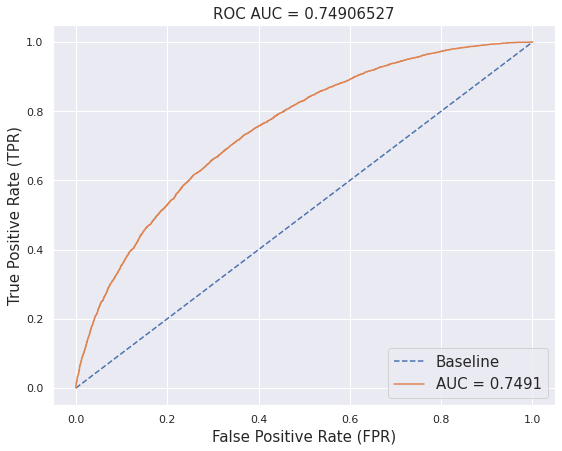

In [29]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 1.470219280565269e-06,
            "lambda_l2": 1.7451260346532275e-07,
            "num_leaves": 9,
            "feature_fraction": 0.9229884275634851,
            "bagging_fraction": 0.5850431445914503,
            "bagging_freq": 5,
            "min_child_samples": 63,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)  # kaggle 0.33825 (35 минут оптимизации)

[LightGBM] [Warning] bagging_fraction is set=0.7039470678830023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7039470678830023
[LightGBM] [Warning] lambda_l1 is set=1.6758594914477627e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6758594914477627e-05
[LightGBM] [Warning] feature_fraction is set=0.4030892028571655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4030892028571655
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=1.555459299457268e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.555459299457268e-07


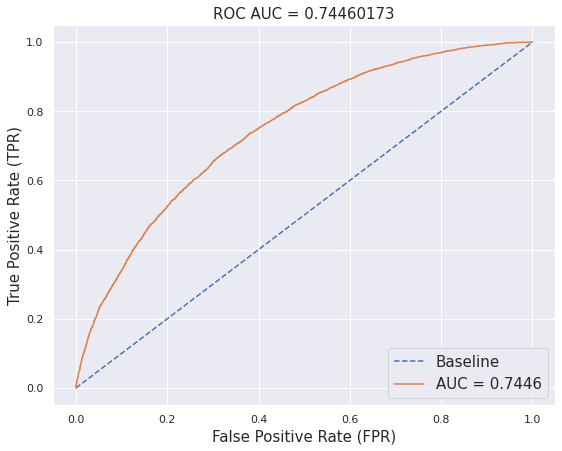

In [30]:
plot_roc_auc(
    y_train_us,
    LGBMClassifier(
        **{
            "lambda_l1": 1.6758594914477627e-05,
            "lambda_l2": 1.555459299457268e-07,
            "num_leaves": 8,
            "feature_fraction": 0.4030892028571655,
            "bagging_fraction": 0.7039470678830023,
            "bagging_freq": 3,
            "min_child_samples": 27,
        }
    )
    .fit(X_train_us, y_train_us)
    .predict_proba(X_train_us)
    .T[1],
)  # kaggle 0.34004 (5 минут оптимизации) <-------------------- пока самый лучший

# final model

здесь уже моделируем для кеггла

In [27]:
# model = LGBMClassifier() # kaggle 0.33657
# model = CatBoostClassifier() # kaggle 0.33794
# model = LogisticRegression() # 0.33933
# model = LogisticRegression(solver='saga', max_iter=1000, random_state=random_seed) # kaggle 0.33933

# model = LGBMClassifier(
#     **{
#         "lambda_l1": 6.636833602368837,
#         "lambda_l2": 0.3221308023736357,
#         "num_leaves": 100,
#         "feature_fraction": 0.4172192685978952,
#         "bagging_fraction": 0.6148275061564304,
#         "bagging_freq": 1,
#         "min_child_samples": 86,
#     }
# )  # kaggle 0.33999

# model = LGBMClassifier(
#     **{
#         "lambda_l1": 1.614857569350475e-07,
#         "lambda_l2": 1.2802161787867987,
#         "num_leaves": 9,
#         "feature_fraction": 0.751603056601776,
#         "bagging_fraction": 0.6317748983491802,
#         "bagging_freq": 3,
#         "min_child_samples": 57,
#     }
# ) # kaggle 0.33929

# model = LGBMClassifier(
#     **{
#         "lambda_l1": 1.470219280565269e-06,
#         "lambda_l2": 1.7451260346532275e-07,
#         "num_leaves": 9,
#         "feature_fraction": 0.9229884275634851,
#         "bagging_fraction": 0.5850431445914503,
#         "bagging_freq": 5,
#         "min_child_samples": 63,
#     }
# ) # kaggle 0.33825

model = LGBMClassifier(
    **{
        "lambda_l1": 1.6758594914477627e-05,
        "lambda_l2": 1.555459299457268e-07,
        "num_leaves": 8,
        "feature_fraction": 0.4030892028571655,
        "bagging_fraction": 0.7039470678830023,
        "bagging_freq": 3,
        "min_child_samples": 27,
    }
)  # kaggle 0.34004 <------------------------------ лучший результат

# model.fit(X_us, y_us)
model.fit(
    X_train_us, y_train_us
)  # понятия не имею почему, но это ВСЕГДА даёт результаты лучше, чем учить на всём доступном трейне
predict_submission = model.predict(test_data)

# submision

готовим файл для сабмишшна, последней кодо-ячейкой, если её раскомментить, можно залить в кеггл прямо из ноутбука

In [28]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

In [29]:
# !kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"

# Kaggle score: $0.34004$